In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import mlflow
import mlflow.sklearn
import mlflow.transformers

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import tensorflow as tf
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import os

from datasets import Dataset

from gensim.models import Word2Vec, FastText

from tqdm import tqdm
from mlflow.tracking import MlflowClient


c:\Users\misss\Formation\Projets\AnalyseSentiments\.env-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('data/tweets_cleaned.csv', encoding='latin-1')

In [3]:
data.head()
print(data['target'].unique())
data['target'] = data['target'].astype(int)
print(data.dtypes)

data['target'].value_counts()

[0 1]
target                       int32
text                        object
text_cleaned                object
text_tfidf                  object
text_lem_with_stopwords     object
text_lem_no_stopwords       object
text_stem_with_stopwords    object
text_stem_no_stopwords      object
text_bert                   object
dtype: object


target
0    800000
1    800000
Name: count, dtype: int64

In [4]:
# Définition de la taille du nouveau dataset
subset_size = 10000

# Calcul du ratio de chaque classe
target_counts = data['target'].value_counts(normalize=True)

# Nombre d'échantillons à prélever pour chaque classe
samples_per_class = (target_counts * subset_size).astype(int)

# Échantillonnage proportionnel
data = pd.concat([
    data[data['target'] == 0].sample(n=samples_per_class[0], random_state=42),
    data[data['target'] == 1].sample(n=samples_per_class[1], random_state=42)
])



In [5]:
data.head()

,target,text,text_cleaned,text_tfidf,text_lem_with_stopwords,text_lem_no_stopwords,text_stem_with_stopwords,text_stem_no_stopwords,text_bert
212188,0,@xnausikaax oh no! where did u order from? tha...,oh no! where did u order from? that's horrible,oh <OOV> <OOV> <OOV> u order <OOV> thats horrible,"['oh', '<OOV>', '<OOV>', '<OOV>', 'u', 'order'...","['oh', 'no', 'where', 'did', 'u', 'order', 'fr...","['oh', '<OOV>', '<OOV>', '<OOV>', 'u', 'order'...","['oh', 'u', 'order', 'that', 'horribl']",<oov> oh no! where did u order from? that's ho...
299036,0,A great hard training weekend is over. a coup...,a great hard training weekend is over. a coup...,<OOV> great hard training weekend <OOV> <OOV> ...,"['<OOV>', 'great', 'hard', 'training', 'weeken...","['a', 'great', 'hard', 'training', 'weekend', ...","['<OOV>', 'great', 'hard', 'train', 'weekend',...","['great', 'hard', 'train', 'weekend', 'coupl',...",a great hard training weekend is over. a coup...
475978,0,"Right, off to work Only 5 hours to go until I...","right, off to work only 5 hours to go until i...",right <OOV> <OOV> work <OOV> 5 hour <OOV> go <...,"['right', '<OOV>', '<OOV>', 'work', '<OOV>', '...","['right', 'off', 'to', 'work', 'only', '5', 'h...","['right', '<OOV>', '<OOV>', 'work', '<OOV>', '...","['right', 'work', '5', 'hour', 'go', 'im', 'fr...","right, off to work only 5 hours to go until i..."
588988,0,I am craving for japanese food,i am craving for japanese food,<OOV> <OOV> craving <OOV> japanese food,"['<OOV>', '<OOV>', 'craving', '<OOV>', 'japane...","['i', 'am', 'craving', 'for', 'japanese', 'food']","['<OOV>', '<OOV>', 'crave', '<OOV>', 'japanes'...","['crave', 'japanes', 'food']",i am craving for japanese food
138859,0,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow got ta work...,"['jean', 'michel', 'jarre', 'concert', 'tomorr...","['jean', 'michel', 'jarre', 'concert', 'tomorr...","['jean', 'michel', 'jarr', 'concert', 'tomorro...","['jean', 'michel', 'jarr', 'concert', 'tomorro...",jean michel jarre concert tomorrow gotta work...


# Decoupage des donnees (Train, Val, Test)

In [5]:
from sklearn.model_selection import train_test_split

# Définition des proportions (70% Train, 15% Validation, 15% Test)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Séparer les features et la target
X = data[['text', 'text_cleaned', 'text_tfidf', 'text_lem_with_stopwords', 'text_lem_no_stopwords','text_stem_with_stopwords','text_stem_no_stopwords', 'text_bert']]  # Garde toutes les variantes de texte
y = data['target']

# 1ère séparation : Train (70%) et Temporaire (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), stratify=y, random_state=42)

# 2ème séparation : Validation (15%) et Test (15%) à partir de Temporaire (30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + val_size), stratify=y_temp, random_state=42)

# Vérification des répartitions
print("Répartition des données après découpage :")
print(f"Train : {len(X_train)} ({y_train.value_counts(normalize=True)})")
print(f"Validation : {len(X_val)} ({y_val.value_counts(normalize=True)})")
print(f"Test : {len(X_test)} ({y_test.value_counts(normalize=True)})")


Répartition des données après découpage :
Train : 6999 (target
1    0.500071
0    0.499929
Name: proportion, dtype: float64)
Validation : 1500 (target
1    0.5
0    0.5
Name: proportion, dtype: float64)
Test : 1501 (target
0    0.500333
1    0.499667
Name: proportion, dtype: float64)


# Fonction de visualisation des donnees

In [6]:


def log_metrics_to_mlflow(model_name, y_test, y_pred, y_prob):
    """
    Log accuracy, F1-score, and ROC-AUC to MLflow
    """
    mlflow.set_experiment(model_name)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    with mlflow.start_run(run_name=model_name):
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.sklearn.log_model(model_name, "model")
    
    print(f"Logged {model_name} - Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}")

def plot_confusion_matrix(y_test, y_pred, model_name):
    """
    Plot and display the confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

def plot_roc_curve(y_test, y_prob, model_name):
    """
    Plot the ROC curve for a model
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

def plot_bar_chart(model_scores, title):
    """
    Plot a bar chart comparing accuracy, F1-score, and ROC-AUC for different models
    """
    labels, accuracy, f1, roc_auc = zip(*model_scores)
    x = np.arange(len(labels))
    width = 0.3
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width, accuracy, width, label='Accuracy')
    ax.bar(x, f1, width, label='F1 Score')
    ax.bar(x + width, roc_auc, width, label='ROC AUC')
    
    ax.set_xlabel("Models")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    
    plt.show()

def plot_boxplot(roc_auc_scores, title):
    """
    Plot a boxplot to show the variability in ROC-AUC scores
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=roc_auc_scores)
    plt.title(title)
    plt.ylabel("ROC AUC Score")
    plt.show()


# Dummy classifier

In [8]:

# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train['text_cleaned'], y_train)

# Prédictions
y_pred = dummy_clf.predict(X_test['text_cleaned'])
y_prob = dummy_clf.predict_proba(X_test['text_cleaned'])[:, 1]  # Probabilité classe positive

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Enregistrement sur MLflow
mlflow.set_experiment("DUMMY_CLASSIFIER")

with mlflow.start_run(run_name="DUMMY_CLASSIFIER"):
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(dummy_clf, "DUMMY_CLASSIFIER_MODEL")
mlflow.end_run()

2025/03/22 19:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


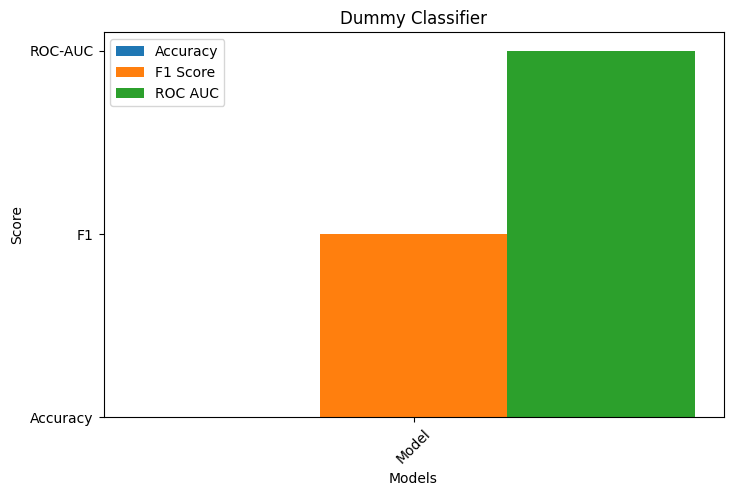

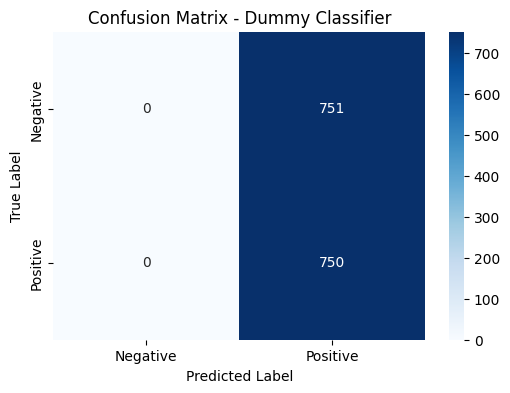

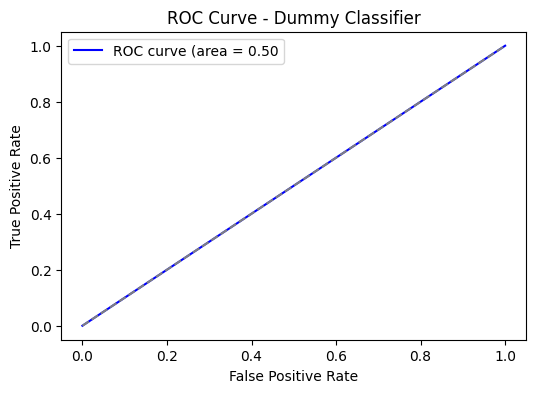

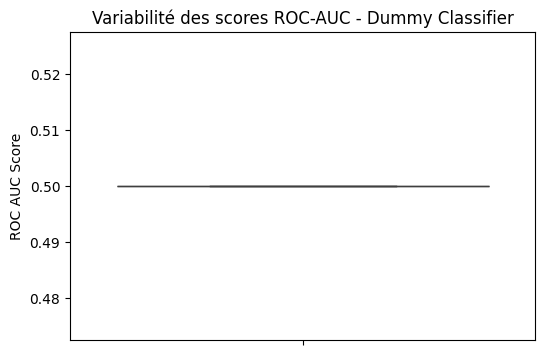

In [9]:
# **Application des Visualisations au Dummy Classifier**
models_scores = [{"Model": "Dummy Classifier", "Accuracy": accuracy, "F1": f1, "ROC-AUC": roc_auc}]
plot_bar_chart(models_scores,"Dummy Classifier" )
plot_confusion_matrix(y_test, y_pred, "Dummy Classifier")
plot_roc_curve(y_test, y_prob, "Dummy Classifier")
roc_auc_scores = [roc_auc]  # On peut ajouter d'autres modèles plus tard
plot_boxplot(roc_auc_scores, "Variabilité des scores ROC-AUC - Dummy Classifier")

#  Modèle Classique (TF-IDF + Régression Logistique)

In [10]:

# Remplacement des NaN par une chaîne vide
X_train['text_tfidf'] = X_train['text_tfidf'].fillna("").astype(str)
X_val['text_tfidf'] = X_val['text_tfidf'].fillna("").astype(str)
X_test['text_tfidf'] = X_test['text_tfidf'].fillna("").astype(str)

# Initialiser le TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Transformer les textes en vecteurs TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train['text_tfidf']).toarray()
X_val_tfidf = vectorizer.transform(X_val['text_tfidf']).toarray()
X_test_tfidf = vectorizer.transform(X_test['text_tfidf']).toarray()

# Conversion des labels en tableaux numpy
y_train_np = y_train.to_numpy(dtype=int)
y_val_np = y_val.to_numpy(dtype=int)
y_test_np = y_test.to_numpy(dtype=int)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s


2025/03/22 19:05:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


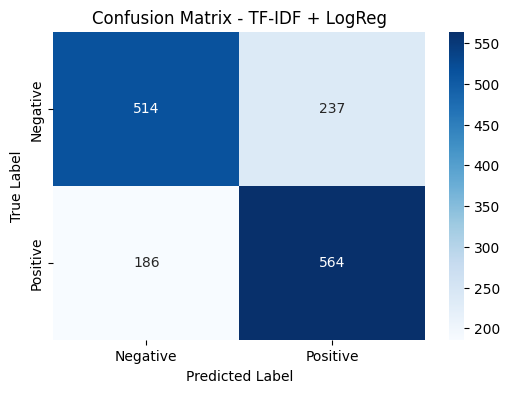

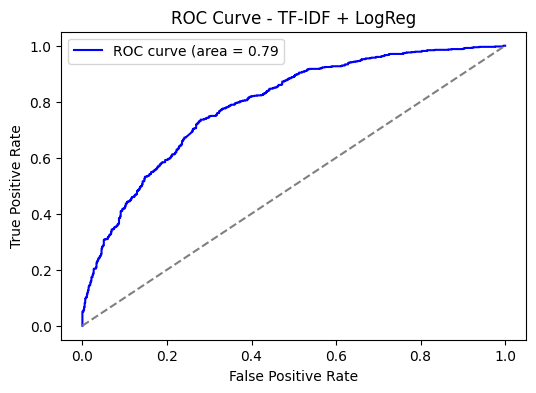

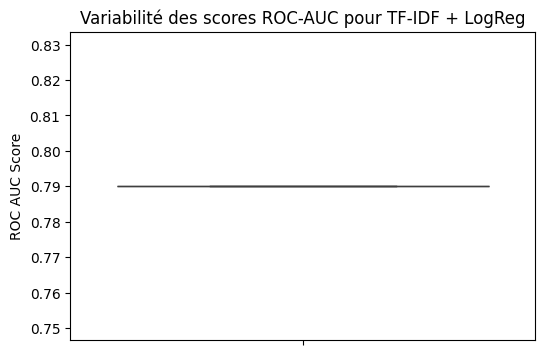

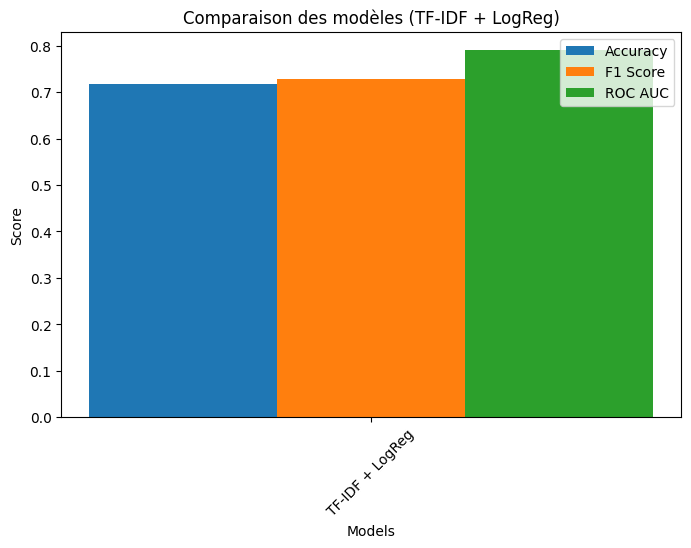

In [11]:
# Définition du pipeline
oov_token = "<OOV>"
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', token_pattern=r'\b\w+\b')),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Définition des hyperparamètres à tester
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.95, 0.90],
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Vérifier et reconvertir en liste de strings
if isinstance(X_train_tfidf, np.ndarray):
    X_train_tfidf = X_train['text_tfidf'].astype(str).tolist()
if isinstance(X_val_tfidf, np.ndarray):
    X_val_tfidf = X_val['text_tfidf'].astype(str).tolist()
if isinstance(X_test_tfidf, np.ndarray):
    X_test_tfidf = X_test['text_tfidf'].astype(str).tolist()

# Exécution du GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_tfidf, y_train)

# Exécution du GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_tfidf, y_train)

# Meilleur modèle trouvé
best_model = grid_search.best_estimator_

# Prédictions sur les données de validation et de test
y_val_pred = best_model.predict(X_val_tfidf)
y_val_prob = best_model.predict_proba(X_val_tfidf)[:, 1]
y_test_pred = best_model.predict(X_test_tfidf)
y_test_prob = best_model.predict_proba(X_test_tfidf)[:, 1]

# Enregistrement des métriques et du modèle dans MLflow
with mlflow.start_run(run_name="TF-IDF_LOGREG"):
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_test_pred))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_test_prob))
    mlflow.sklearn.log_model(best_model, "TF-IDF_LOGREG_MODEL")
mlflow.end_run()
# Visualisation des performances
plot_confusion_matrix(y_test, y_test_pred, "TF-IDF + LogReg")
plot_roc_curve(y_test, y_test_prob, "TF-IDF + LogReg")

# Boxplot des scores ROC-AUC
roc_auc_scores = {'TF-IDF + LogReg': roc_auc_score(y_test, y_test_prob)}
plot_boxplot(roc_auc_scores, "Variabilité des scores ROC-AUC pour TF-IDF + LogReg")

# Comparaison avec d'autres modèles
model_scores = [
    ("TF-IDF + LogReg", accuracy_score(y_test, y_test_pred),
     f1_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob))
]
plot_bar_chart(model_scores, "Comparaison des modèles (TF-IDF + LogReg)")


# Word Embeddings (Word2Vec / FastText) + LSTM


  Entraînement du modèle LSTM avec Word2Vec_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 53s 441ms/step - loss: 0.6975 - accuracy: 0.5096 - val_loss: 0.6960 - val_accuracy: 0.5160
Epoch 2/10
110/110 [==============================] - 31s 282ms/step - loss: 0.6940 - accuracy: 0.5248 - val_loss: 0.6871 - val_accuracy: 0.5393
Epoch 3/10
110/110 [==============================] - 32s 288ms/step - loss: 0.6902 - accuracy: 0.5296 - val_loss: 0.6924 - val_accuracy: 0.5233
Epoch 4/10
110/110 [==============================] - 31s 282ms/step - loss: 0.6926 - accuracy: 0.5254 - val_loss: 0.6988 - val_accuracy: 0.4987
Epoch 5/10
110/110 [==============================] - 30s 272ms/step - loss: 0.6924 - accuracy: 0.5244 - val_loss: 0.6874 - val_accuracy: 0.5413
Epoch 6/10
110/110 [==============================] - 32s 296ms/step - loss: 0.6914 - accuracy: 0.5266 - val_loss: 0.6885 - val_accuracy: 0.5487
Epoch 7/10
110/110 [==============================] - 30s

2025/03/22 19:11:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp2cjrhqc9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp2cjrhqc9\model\data\model\assets
2025/03/22 19:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_with_stopwords : Accuracy = 0.5383, F1 Score = 0.4162, ROC AUC = 0.5484


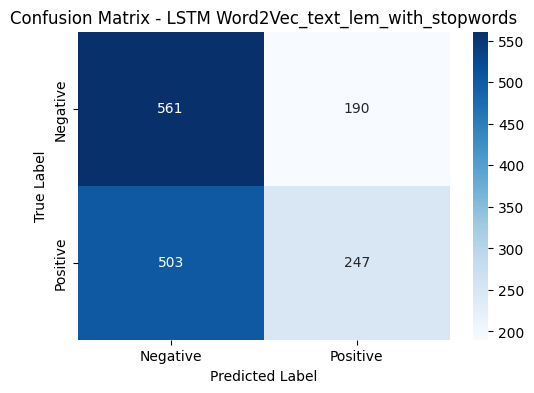

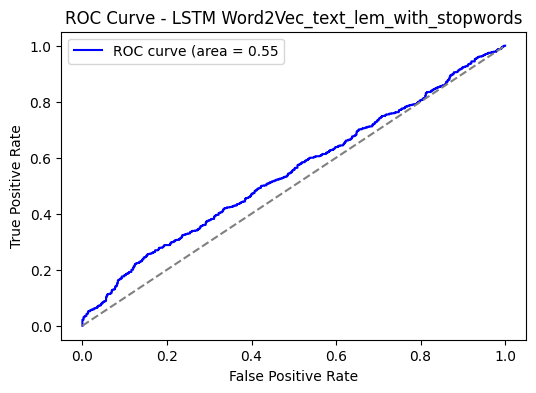


  Entraînement du modèle LSTM avec FastText_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 49s 404ms/step - loss: 0.6961 - accuracy: 0.5149 - val_loss: 0.6905 - val_accuracy: 0.5467
Epoch 2/10
110/110 [==============================] - 42s 384ms/step - loss: 0.6935 - accuracy: 0.5196 - val_loss: 0.6887 - val_accuracy: 0.5367
Epoch 3/10
110/110 [==============================] - 42s 384ms/step - loss: 0.6914 - accuracy: 0.5298 - val_loss: 0.6865 - val_accuracy: 0.5493
Epoch 4/10
110/110 [==============================] - 42s 383ms/step - loss: 0.6907 - accuracy: 0.5405 - val_loss: 0.6873 - val_accuracy: 0.5507
Epoch 5/10
110/110 [==============================] - 42s 386ms/step - loss: 0.6895 - accuracy: 0.5299 - val_loss: 0.6867 - val_accuracy: 0.5327
Epoch 6/10
110/110 [==============================] - 46s 414ms/step - loss: 0.6877 - accuracy: 0.5386 - val_loss: 0.6816 - val_accuracy: 0.5607
Epoch 7/10
110/110 [==============================] - 48s

2025/03/22 19:19:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpjzns2atw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpjzns2atw\model\data\model\assets
2025/03/22 19:19:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_with_stopwords : Accuracy = 0.5383, F1 Score = 0.4062, ROC AUC = 0.5517


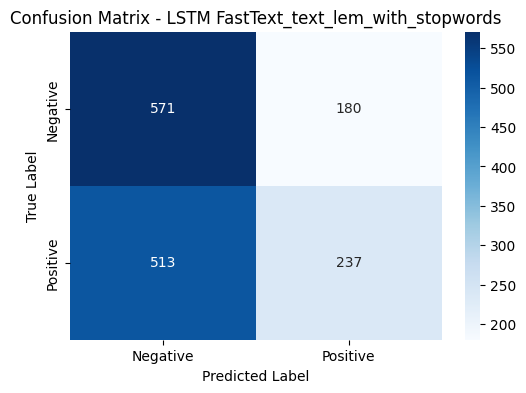

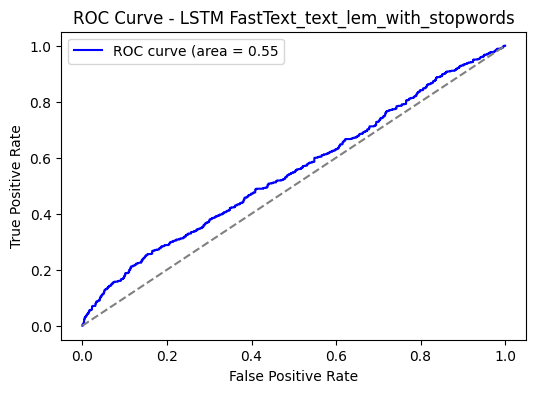


  Entraînement du modèle LSTM avec Word2Vec_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 53s 434ms/step - loss: 0.6970 - accuracy: 0.5016 - val_loss: 0.6911 - val_accuracy: 0.5320
Epoch 2/10
110/110 [==============================] - 61s 551ms/step - loss: 0.6944 - accuracy: 0.5148 - val_loss: 0.6961 - val_accuracy: 0.4993
Epoch 3/10
110/110 [==============================] - 60s 547ms/step - loss: 0.6946 - accuracy: 0.5105 - val_loss: 0.6930 - val_accuracy: 0.5013
Epoch 4/10
110/110 [==============================] - 59s 540ms/step - loss: 0.6932 - accuracy: 0.5064 - val_loss: 0.6901 - val_accuracy: 0.5347
Epoch 5/10
110/110 [==============================] - 60s 550ms/step - loss: 0.6931 - accuracy: 0.5202 - val_loss: 0.6901 - val_accuracy: 0.5320
Epoch 6/10
110/110 [==============================] - 61s 555ms/step - loss: 0.6913 - accuracy: 0.5272 - val_loss: 0.6947 - val_accuracy: 0.5373
Epoch 7/10
110/110 [==============================] - 60s 5

2025/03/22 19:29:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_mwe_758\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_mwe_758\model\data\model\assets
2025/03/22 19:30:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_no_stopwords : Accuracy = 0.5383, F1 Score = 0.5295, ROC AUC = 0.5580


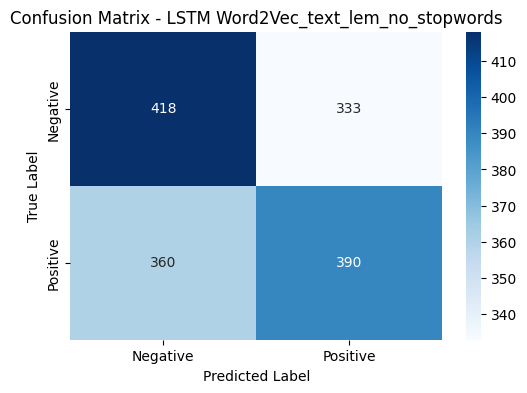

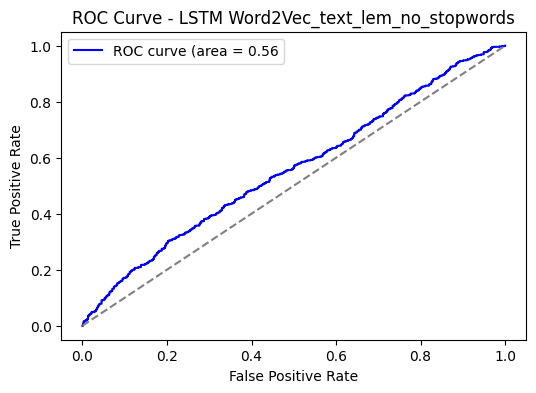


  Entraînement du modèle LSTM avec FastText_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 147s 1s/step - loss: 0.6975 - accuracy: 0.5056 - val_loss: 0.6934 - val_accuracy: 0.4993
Epoch 2/10
110/110 [==============================] - 98s 888ms/step - loss: 0.6945 - accuracy: 0.5132 - val_loss: 0.6915 - val_accuracy: 0.5347
Epoch 3/10
110/110 [==============================] - 98s 896ms/step - loss: 0.6938 - accuracy: 0.5156 - val_loss: 0.6942 - val_accuracy: 0.4993
Epoch 4/10
110/110 [==============================] - 99s 902ms/step - loss: 0.6935 - accuracy: 0.5116 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/10
110/110 [==============================] - 103s 939ms/step - loss: 0.6922 - accuracy: 0.5206 - val_loss: 0.6925 - val_accuracy: 0.4980
Epoch 6/10
110/110 [==============================] - 104s 943ms/step - loss: 0.6932 - accuracy: 0.5156 - val_loss: 0.6923 - val_accuracy: 0.5320
Epoch 7/10
110/110 [==============================] - 103s 

2025/03/22 19:47:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_6omubpf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_6omubpf\model\data\model\assets
2025/03/22 19:48:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_no_stopwords : Accuracy = 0.5343, F1 Score = 0.5362, ROC AUC = 0.5600


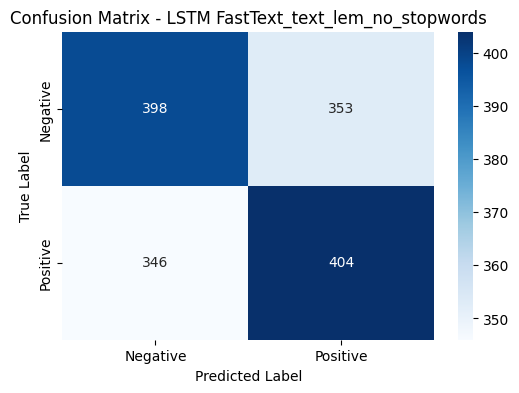

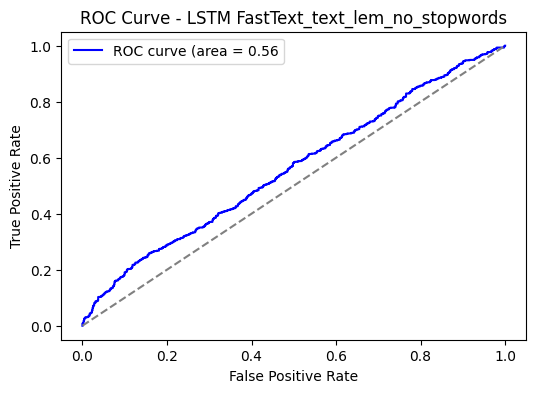


  Entraînement du modèle LSTM avec Word2Vec_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 213s 2s/step - loss: 0.6959 - accuracy: 0.5092 - val_loss: 0.6894 - val_accuracy: 0.5267
Epoch 2/10
110/110 [==============================] - 216s 2s/step - loss: 0.6923 - accuracy: 0.5276 - val_loss: 0.6964 - val_accuracy: 0.4993
Epoch 3/10
110/110 [==============================] - 216s 2s/step - loss: 0.6917 - accuracy: 0.5249 - val_loss: 0.6917 - val_accuracy: 0.5113
Epoch 4/10
110/110 [==============================] - 216s 2s/step - loss: 0.6901 - accuracy: 0.5266 - val_loss: 0.6852 - val_accuracy: 0.5560
Epoch 5/10
110/110 [==============================] - 216s 2s/step - loss: 0.6895 - accuracy: 0.5306 - val_loss: 0.6874 - val_accuracy: 0.5487
Epoch 6/10
110/110 [==============================] - 216s 2s/step - loss: 0.6889 - accuracy: 0.5316 - val_loss: 0.6859 - val_accuracy: 0.5613
Epoch 7/10
110/110 [==============================] - 216s 2s/step -

2025/03/22 20:24:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp5qocqec1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp5qocqec1\model\data\model\assets
2025/03/22 20:25:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_with_stopwords : Accuracy = 0.5423, F1 Score = 0.4062, ROC AUC = 0.5486


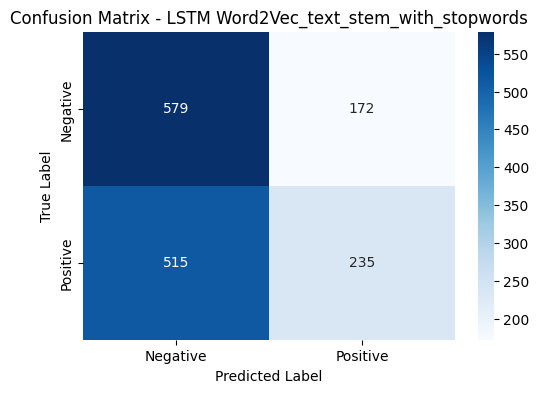

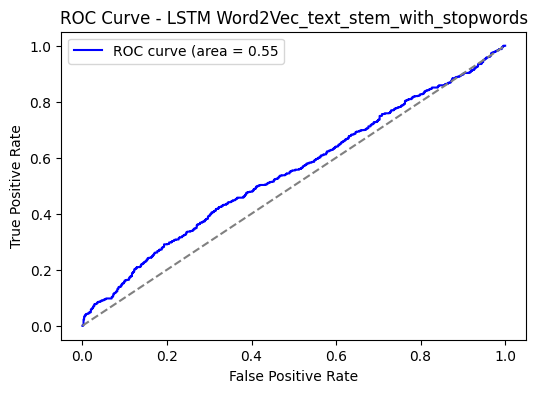


  Entraînement du modèle LSTM avec FastText_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 294s 3s/step - loss: 0.6975 - accuracy: 0.5089 - val_loss: 0.6916 - val_accuracy: 0.5427
Epoch 2/10
110/110 [==============================] - 245s 2s/step - loss: 0.6933 - accuracy: 0.5196 - val_loss: 0.6894 - val_accuracy: 0.5493
Epoch 3/10
110/110 [==============================] - 245s 2s/step - loss: 0.6918 - accuracy: 0.5244 - val_loss: 0.6892 - val_accuracy: 0.5273
Epoch 4/10
110/110 [==============================] - 245s 2s/step - loss: 0.6907 - accuracy: 0.5328 - val_loss: 0.6889 - val_accuracy: 0.5367
Epoch 5/10
110/110 [==============================] - 243s 2s/step - loss: 0.6899 - accuracy: 0.5404 - val_loss: 0.6883 - val_accuracy: 0.5520
Epoch 6/10
110/110 [==============================] - 245s 2s/step - loss: 0.6887 - accuracy: 0.5412 - val_loss: 0.6867 - val_accuracy: 0.5580
Epoch 7/10
110/110 [==============================] - 248s 2s/step -

2025/03/22 21:07:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp88y6clb2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp88y6clb2\model\data\model\assets
2025/03/22 21:07:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_with_stopwords : Accuracy = 0.5363, F1 Score = 0.3495, ROC AUC = 0.5431


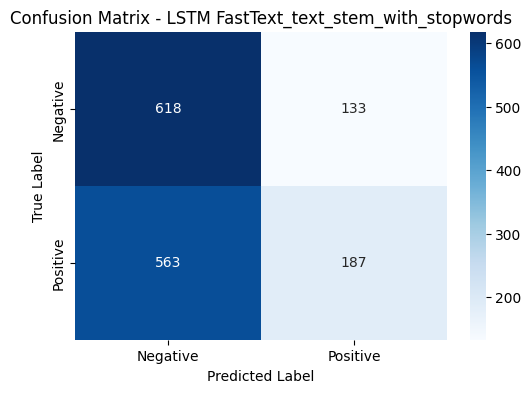

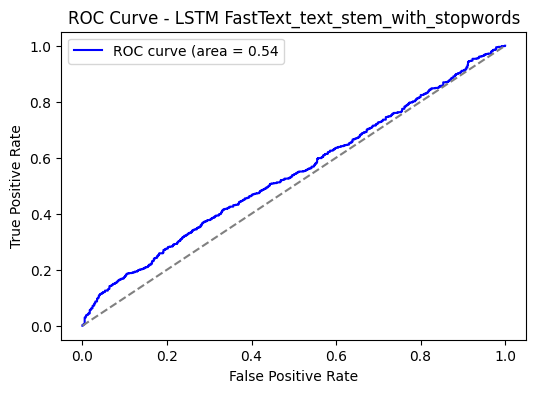


  Entraînement du modèle LSTM avec Word2Vec_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 297s 3s/step - loss: 0.6973 - accuracy: 0.5038 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 255s 2s/step - loss: 0.6961 - accuracy: 0.5054 - val_loss: 0.6940 - val_accuracy: 0.4993
Epoch 3/10
110/110 [==============================] - 254s 2s/step - loss: 0.6947 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 4/10
110/110 [==============================] - 255s 2s/step - loss: 0.6942 - accuracy: 0.5121 - val_loss: 0.6933 - val_accuracy: 0.4993
Epoch 5/10
110/110 [==============================] - 255s 2s/step - loss: 0.6936 - accuracy: 0.5075 - val_loss: 0.6924 - val_accuracy: 0.5267
Epoch 6/10
110/110 [==============================] - 255s 2s/step - loss: 0.6932 - accuracy: 0.5081 - val_loss: 0.6916 - val_accuracy: 0.5300
Epoch 7/10
110/110 [==============================] - 255s 2s/step - l

2025/03/22 21:50:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpe51czmkq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpe51czmkq\model\data\model\assets
2025/03/22 21:51:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_no_stopwords : Accuracy = 0.5023, F1 Score = 0.5386, ROC AUC = 0.5071


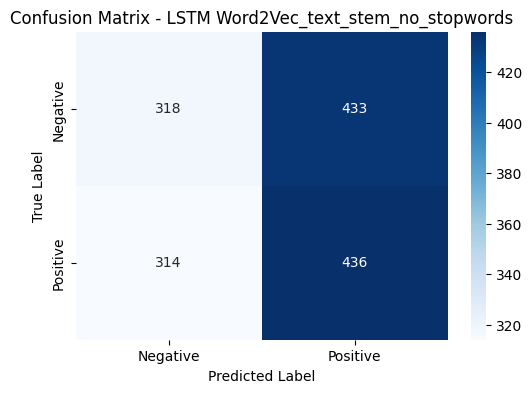

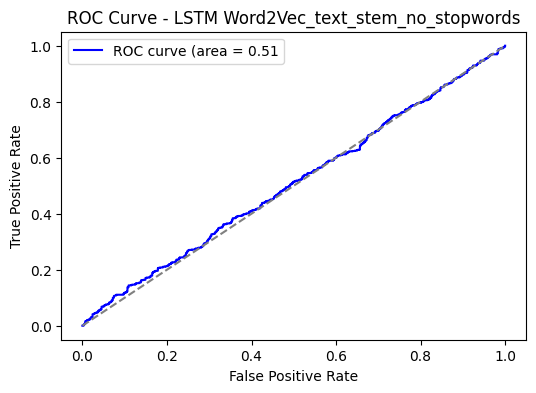


  Entraînement du modèle LSTM avec FastText_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 285s 3s/step - loss: 0.6971 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.5047
Epoch 2/10
110/110 [==============================] - 279s 3s/step - loss: 0.6953 - accuracy: 0.5038 - val_loss: 0.6937 - val_accuracy: 0.4993
Epoch 3/10
110/110 [==============================] - 278s 3s/step - loss: 0.6938 - accuracy: 0.5132 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 4/10
110/110 [==============================] - 278s 3s/step - loss: 0.6950 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 5/10
110/110 [==============================] - 279s 3s/step - loss: 0.6951 - accuracy: 0.5061 - val_loss: 0.6929 - val_accuracy: 0.5080
Epoch 6/10
110/110 [==============================] - 279s 3s/step - loss: 0.6927 - accuracy: 0.5144 - val_loss: 0.6930 - val_accuracy: 0.5067
Epoch 7/10
110/110 [==============================] - 278s 3s/step - l

2025/03/22 22:38:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmplk3coju1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmplk3coju1\model\data\model\assets
2025/03/22 22:38:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_no_stopwords : Accuracy = 0.5010, F1 Score = 0.5790, ROC AUC = 0.5185


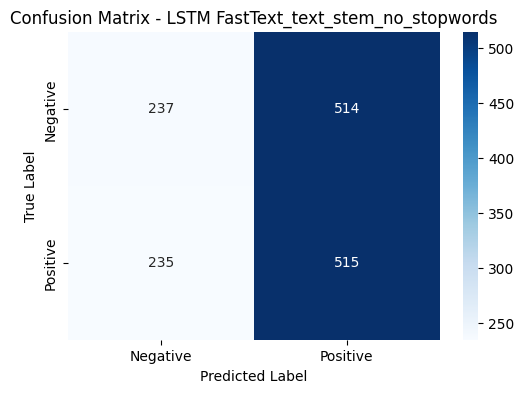

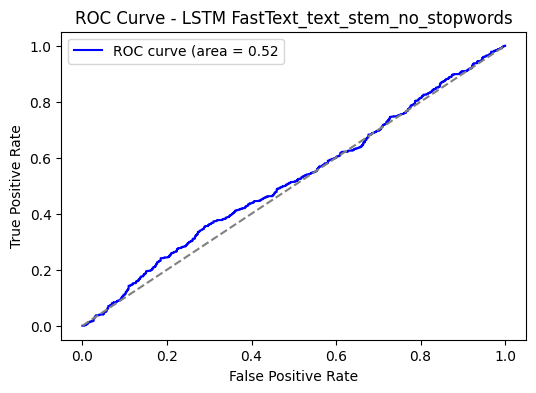

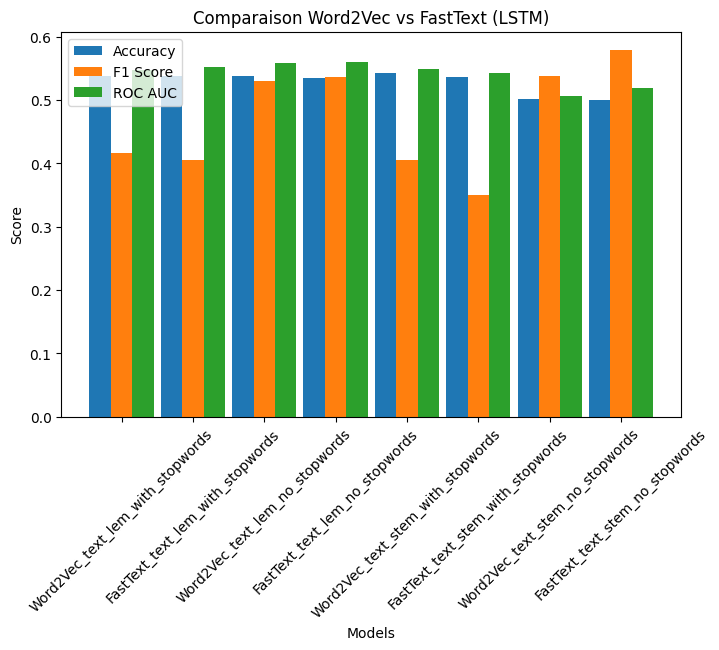

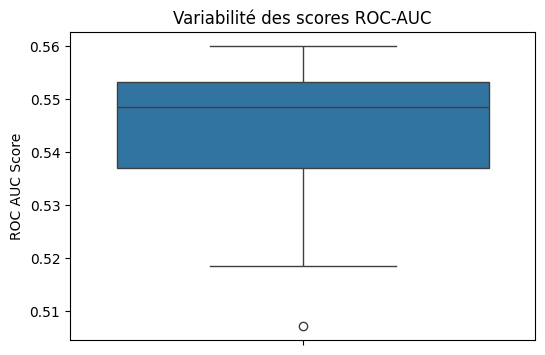

In [12]:
# Hyperparamètres
EMBEDDING_DIM = 100  
MAX_SEQUENCE_LENGTH = 100  
BATCH_SIZE = 64
EPOCHS = 10

# Dictionnaire pour stocker les modèles d'embeddings
embedding_models = {}

# Colonnes de texte à tester
text_columns = [
    "text_lem_with_stopwords", 
    "text_lem_no_stopwords", 
    "text_stem_with_stopwords", 
    "text_stem_no_stopwords"
]

# Entraîner un modèle Word2Vec et FastText pour chaque type de texte
for col in text_columns:
    sentences = data[col].tolist()  # Récupérer les phrases sous forme de liste de tokens
    
    embedding_models[f"Word2Vec_{col}"] = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4)
    embedding_models[f"FastText_{col}"] = FastText(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4)

# Convertir les tokens en séquences d'indices
word_indices = {}  
embedding_matrices = {}  

special_token = "<OOV>"

def build_embedding_matrix(model, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix

# Construire les matrices d'embeddings pour chaque modèle entraîné
for name, model in embedding_models.items():
    model.build_vocab([[special_token]], update=True)
    model.wv[special_token] = np.zeros((EMBEDDING_DIM,))
    word_indices[name] = {word: i+1 for i, word in enumerate(model.wv.index_to_key)}
    embedding_matrices[name] = build_embedding_matrix(model, word_indices[name], EMBEDDING_DIM)

# Convertir les tokens en séquences avec PyTorch
def tokens_to_sequences(tokens_list, word_index, max_length):
    sequences = [[word_index.get(word, word_index.get(special_token, 0)) for word in tokens] for tokens in tokens_list]
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Stocker les performances
model_scores = []

#  Construire un modèle LSTM
def build_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, 
                  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
        Dropout(0.5),
        Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid')),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model

#  Entraîner et comparer les modèles
for embedding_name in embedding_models.keys():
    print(f"\n  Entraînement du modèle LSTM avec {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]
    
    #  Transformation des données avec PyTorch
    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)


    # Construire le modèle LSTM avec TensorFlow
    model = build_lstm_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"LSTM_{embedding_name}")

    with mlflow.start_run(run_name=f"LSTM_{embedding_name}"):

        # Entraînement du modèle avec les données transformées depuis PyTorch
        history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

        #  Prédiction
        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        #  Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        #  Enregistrement dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.keras.log_model(model, f"lstm_{embedding_name}_model")

        print(f" Modèle {embedding_name} : Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

        #  Stocker les scores
        model_scores.append((embedding_name, accuracy, f1, roc_auc))

        #  Visualisation
        plot_confusion_matrix(y_test, y_pred, f"LSTM {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"LSTM {embedding_name}")
mlflow.end_run()

#  Comparaison des modèles avec Bar Chart et Boxplot
plot_bar_chart(model_scores, "Comparaison Word2Vec vs FastText (LSTM)")
roc_auc_values = [score[3] for score in model_scores]  
plot_boxplot(roc_auc_values, "Variabilité des scores ROC-AUC")


# CNN avec Word Embeddings


  Entraînement du modèle CNN avec Word2Vec_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 9s 74ms/step - loss: 0.7020 - accuracy: 0.5196 - val_loss: 0.6910 - val_accuracy: 0.5113
Epoch 2/10
110/110 [==============================] - 8s 72ms/step - loss: 0.6894 - accuracy: 0.5302 - val_loss: 0.6859 - val_accuracy: 0.5300
Epoch 3/10
110/110 [==============================] - 8s 70ms/step - loss: 0.6824 - accuracy: 0.5456 - val_loss: 0.6795 - val_accuracy: 0.5713
Epoch 4/10
110/110 [==============================] - 8s 71ms/step - loss: 0.6736 - accuracy: 0.5712 - val_loss: 0.6769 - val_accuracy: 0.5687
Epoch 5/10
110/110 [==============================] - 8s 72ms/step - loss: 0.6587 - accuracy: 0.6022 - val_loss: 0.6731 - val_accuracy: 0.5760
Epoch 6/10
110/110 [==============================] - 8s 72ms/step - loss: 0.6333 - accuracy: 0.6312 - val_loss: 0.6623 - val_accuracy: 0.6107
Epoch 7/10
110/110 [==============================] - 8s 72ms/step - l

2025/03/22 22:39:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmprhrf2bmr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmprhrf2bmr\model\data\model\assets
2025/03/22 22:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_with_stopwords : Accuracy = 0.5776, F1 Score = 0.5634, ROC AUC = 0.6200


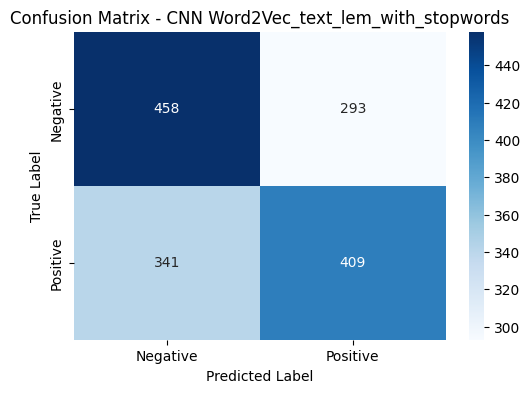

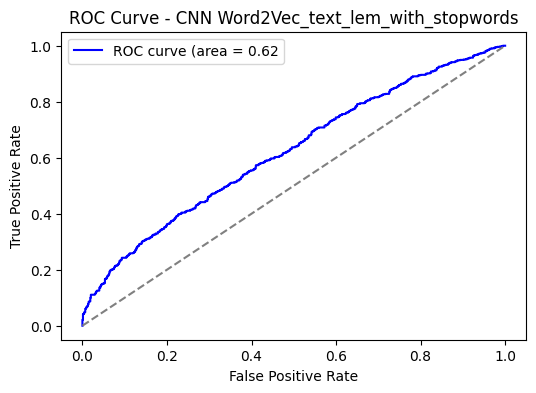


  Entraînement du modèle CNN avec FastText_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 8s 71ms/step - loss: 0.7031 - accuracy: 0.5262 - val_loss: 0.6882 - val_accuracy: 0.5327
Epoch 2/10
110/110 [==============================] - 8s 68ms/step - loss: 0.6871 - accuracy: 0.5368 - val_loss: 0.6812 - val_accuracy: 0.5493
Epoch 3/10
110/110 [==============================] - 8s 69ms/step - loss: 0.6752 - accuracy: 0.5662 - val_loss: 0.6783 - val_accuracy: 0.5673
Epoch 4/10
110/110 [==============================] - 7s 68ms/step - loss: 0.6609 - accuracy: 0.5899 - val_loss: 0.6759 - val_accuracy: 0.5820
Epoch 5/10
110/110 [==============================] - 7s 68ms/step - loss: 0.6400 - accuracy: 0.6262 - val_loss: 0.6643 - val_accuracy: 0.6013
Epoch 6/10
110/110 [==============================] - 7s 68ms/step - loss: 0.6070 - accuracy: 0.6582 - val_loss: 0.6623 - val_accuracy: 0.6047
Epoch 7/10
110/110 [==============================] - 8s 69ms/step - l

2025/03/22 22:41:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpd34nn_u9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpd34nn_u9\model\data\model\assets
2025/03/22 22:41:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_with_stopwords : Accuracy = 0.5803, F1 Score = 0.5882, ROC AUC = 0.6166


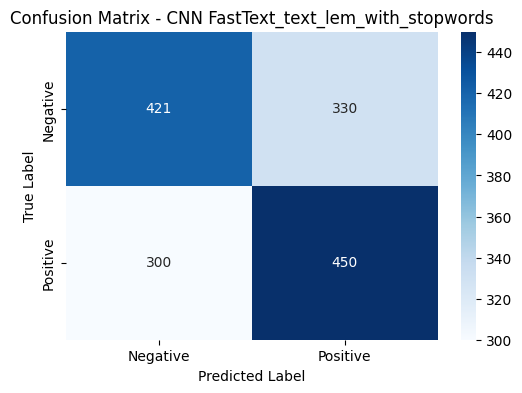

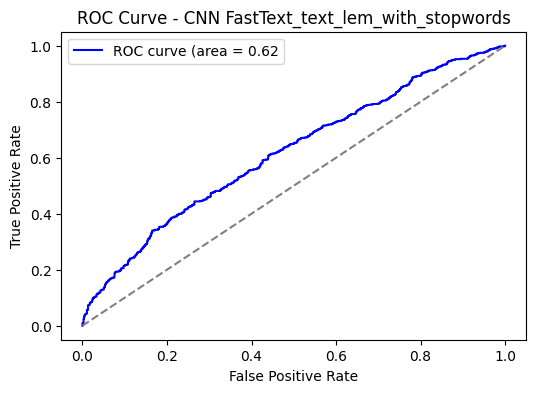


  Entraînement du modèle CNN avec Word2Vec_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 6s 40ms/step - loss: 0.7082 - accuracy: 0.4995 - val_loss: 0.6922 - val_accuracy: 0.5240
Epoch 2/10
110/110 [==============================] - 4s 39ms/step - loss: 0.6909 - accuracy: 0.5281 - val_loss: 0.6868 - val_accuracy: 0.5647
Epoch 3/10
110/110 [==============================] - 4s 39ms/step - loss: 0.6792 - accuracy: 0.5711 - val_loss: 0.6852 - val_accuracy: 0.5647
Epoch 4/10
110/110 [==============================] - 4s 39ms/step - loss: 0.6671 - accuracy: 0.5905 - val_loss: 0.6958 - val_accuracy: 0.5460
Epoch 5/10
110/110 [==============================] - 4s 39ms/step - loss: 0.6499 - accuracy: 0.6179 - val_loss: 0.6727 - val_accuracy: 0.5987
Epoch 6/10
110/110 [==============================] - 4s 39ms/step - loss: 0.6203 - accuracy: 0.6552 - val_loss: 0.6714 - val_accuracy: 0.5907
Epoch 7/10
110/110 [==============================] - 4s 39ms/step - los

2025/03/22 22:42:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp8a7aaq90\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp8a7aaq90\model\data\model\assets
2025/03/22 22:42:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_no_stopwords : Accuracy = 0.6129, F1 Score = 0.5436, ROC AUC = 0.6599


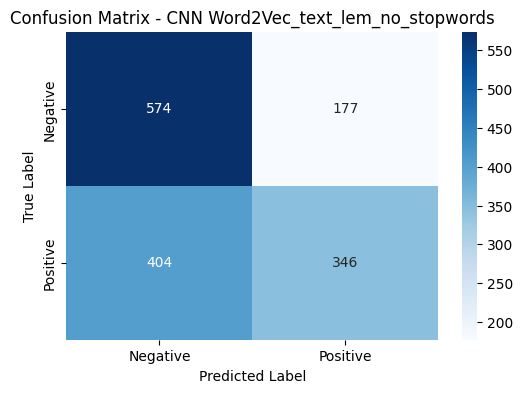

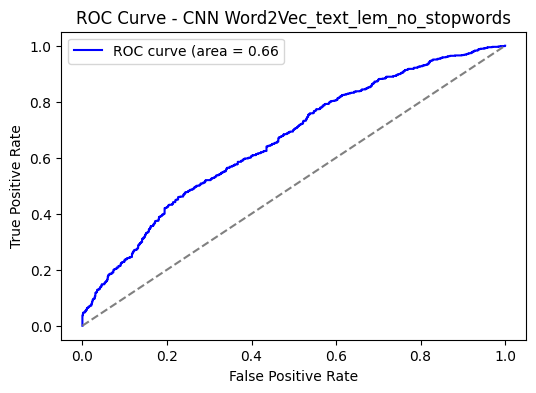


  Entraînement du modèle CNN avec FastText_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 5s 42ms/step - loss: 0.7080 - accuracy: 0.5064 - val_loss: 0.6939 - val_accuracy: 0.5293
Epoch 2/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6909 - accuracy: 0.5204 - val_loss: 0.6919 - val_accuracy: 0.5447
Epoch 3/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6835 - accuracy: 0.5491 - val_loss: 0.6835 - val_accuracy: 0.5673
Epoch 4/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6671 - accuracy: 0.5897 - val_loss: 0.6772 - val_accuracy: 0.5733
Epoch 5/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6451 - accuracy: 0.6185 - val_loss: 0.6747 - val_accuracy: 0.6020
Epoch 6/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6110 - accuracy: 0.6638 - val_loss: 0.6787 - val_accuracy: 0.5873
Epoch 7/10
110/110 [==============================] - 4s 40ms/step - los

2025/03/22 22:42:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp6ftcku6l\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp6ftcku6l\model\data\model\assets
2025/03/22 22:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_no_stopwords : Accuracy = 0.5876, F1 Score = 0.6119, ROC AUC = 0.6289


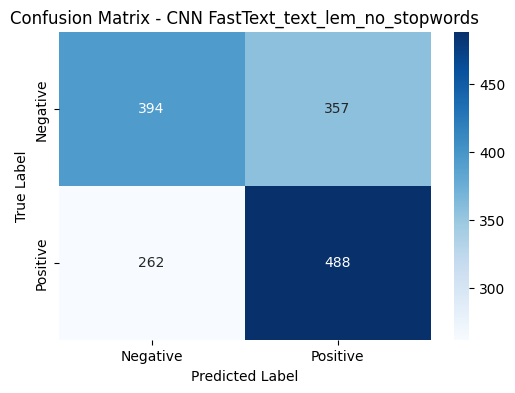

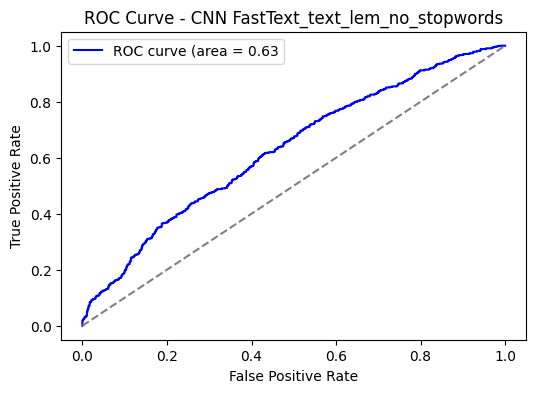


  Entraînement du modèle CNN avec Word2Vec_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 5s 42ms/step - loss: 0.7036 - accuracy: 0.5204 - val_loss: 0.6897 - val_accuracy: 0.5180
Epoch 2/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6843 - accuracy: 0.5432 - val_loss: 0.6841 - val_accuracy: 0.5540
Epoch 3/10
110/110 [==============================] - 5s 41ms/step - loss: 0.6763 - accuracy: 0.5611 - val_loss: 0.6814 - val_accuracy: 0.5613
Epoch 4/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6635 - accuracy: 0.5898 - val_loss: 0.6798 - val_accuracy: 0.5713
Epoch 5/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6410 - accuracy: 0.6251 - val_loss: 0.6808 - val_accuracy: 0.5693
Epoch 6/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6071 - accuracy: 0.6594 - val_loss: 0.6791 - val_accuracy: 0.5933
Epoch 7/10
110/110 [==============================] - 4s 41ms/step - 

2025/03/22 22:43:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpwfwcvur9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpwfwcvur9\model\data\model\assets
2025/03/22 22:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_with_stopwords : Accuracy = 0.5690, F1 Score = 0.5887, ROC AUC = 0.5991


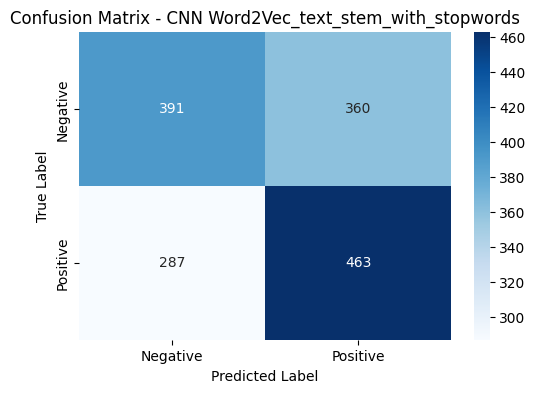

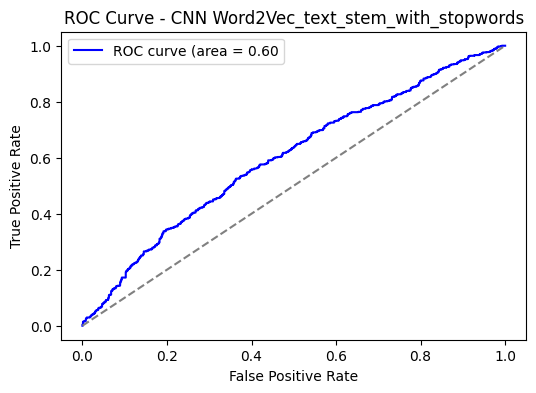


  Entraînement du modèle CNN avec FastText_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 5s 42ms/step - loss: 0.7122 - accuracy: 0.5124 - val_loss: 0.6903 - val_accuracy: 0.5140
Epoch 2/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6905 - accuracy: 0.5346 - val_loss: 0.6882 - val_accuracy: 0.5527
Epoch 3/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6854 - accuracy: 0.5418 - val_loss: 0.6855 - val_accuracy: 0.5473
Epoch 4/10
110/110 [==============================] - 5s 41ms/step - loss: 0.6738 - accuracy: 0.5662 - val_loss: 0.6845 - val_accuracy: 0.5633
Epoch 5/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6684 - accuracy: 0.5809 - val_loss: 0.6830 - val_accuracy: 0.5600
Epoch 6/10
110/110 [==============================] - 5s 41ms/step - loss: 0.6483 - accuracy: 0.6051 - val_loss: 0.6836 - val_accuracy: 0.5687
Epoch 7/10
110/110 [==============================] - 4s 41ms/step - 

2025/03/22 22:44:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpbpvq9tkw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpbpvq9tkw\model\data\model\assets
2025/03/22 22:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_with_stopwords : Accuracy = 0.5716, F1 Score = 0.5436, ROC AUC = 0.6074


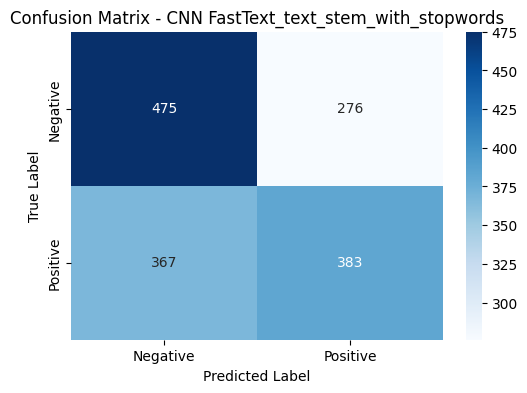

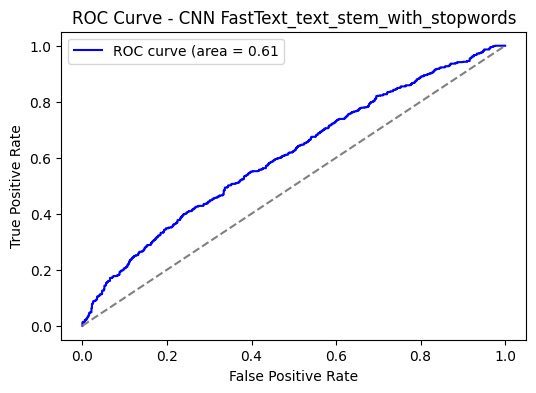


  Entraînement du modèle CNN avec Word2Vec_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 5s 42ms/step - loss: 0.7040 - accuracy: 0.5124 - val_loss: 0.6937 - val_accuracy: 0.5013
Epoch 2/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6897 - accuracy: 0.5342 - val_loss: 0.6911 - val_accuracy: 0.5373
Epoch 3/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6824 - accuracy: 0.5618 - val_loss: 0.6839 - val_accuracy: 0.5527
Epoch 4/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6679 - accuracy: 0.5877 - val_loss: 0.6803 - val_accuracy: 0.5627
Epoch 5/10
110/110 [==============================] - 4s 41ms/step - loss: 0.6463 - accuracy: 0.6199 - val_loss: 0.6787 - val_accuracy: 0.5740
Epoch 6/10
110/110 [==============================] - 5s 41ms/step - loss: 0.6238 - accuracy: 0.6448 - val_loss: 0.6779 - val_accuracy: 0.5827
Epoch 7/10
110/110 [==============================] - 4s 40ms/step - lo

2025/03/22 22:45:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpv6224x2u\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpv6224x2u\model\data\model\assets
2025/03/22 22:45:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_no_stopwords : Accuracy = 0.5776, F1 Score = 0.5941, ROC AUC = 0.6168


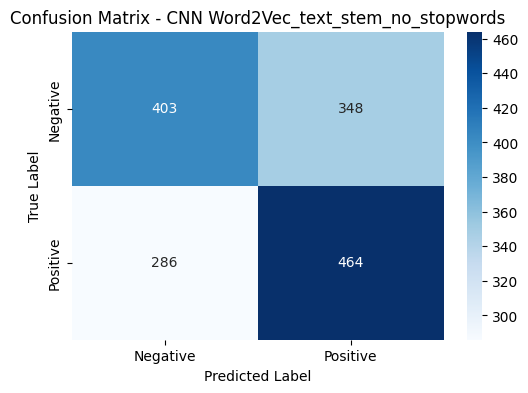

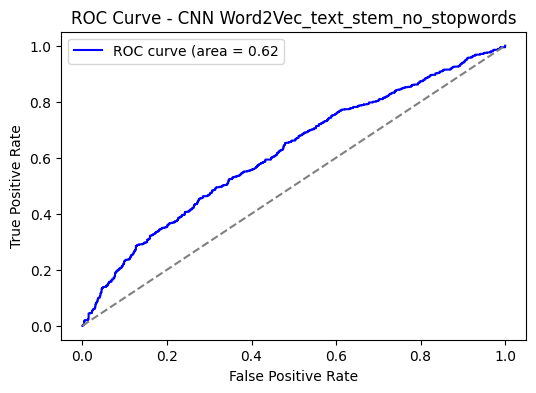


  Entraînement du modèle CNN avec FastText_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 6s 51ms/step - loss: 0.7002 - accuracy: 0.5018 - val_loss: 0.6924 - val_accuracy: 0.5173
Epoch 2/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6914 - accuracy: 0.5112 - val_loss: 0.6907 - val_accuracy: 0.5160
Epoch 3/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6881 - accuracy: 0.5332 - val_loss: 0.6858 - val_accuracy: 0.5387
Epoch 4/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6788 - accuracy: 0.5567 - val_loss: 0.6735 - val_accuracy: 0.5747
Epoch 5/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6655 - accuracy: 0.5859 - val_loss: 0.6702 - val_accuracy: 0.5647
Epoch 6/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6474 - accuracy: 0.6157 - val_loss: 0.6655 - val_accuracy: 0.5873
Epoch 7/10
110/110 [==============================] - 6s 50ms/step - lo

2025/03/22 22:46:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp5easxu67\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp5easxu67\model\data\model\assets
2025/03/22 22:46:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_no_stopwords : Accuracy = 0.5909, F1 Score = 0.5934, ROC AUC = 0.6293


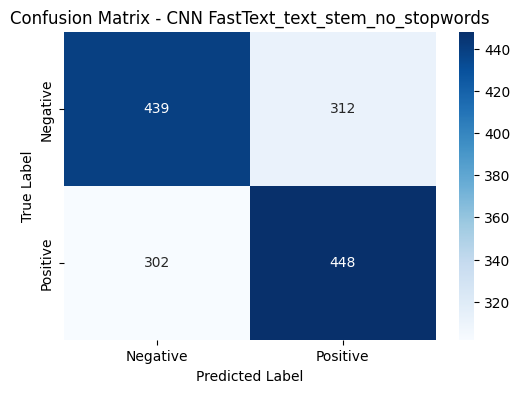

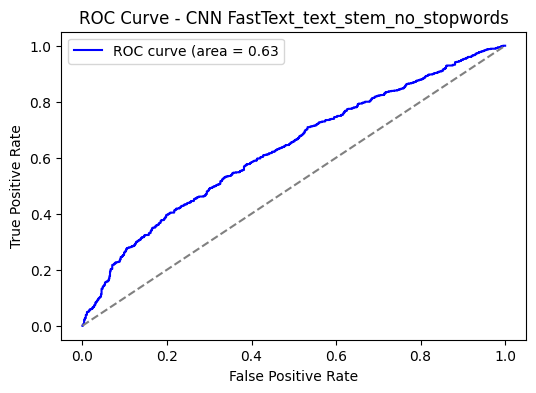

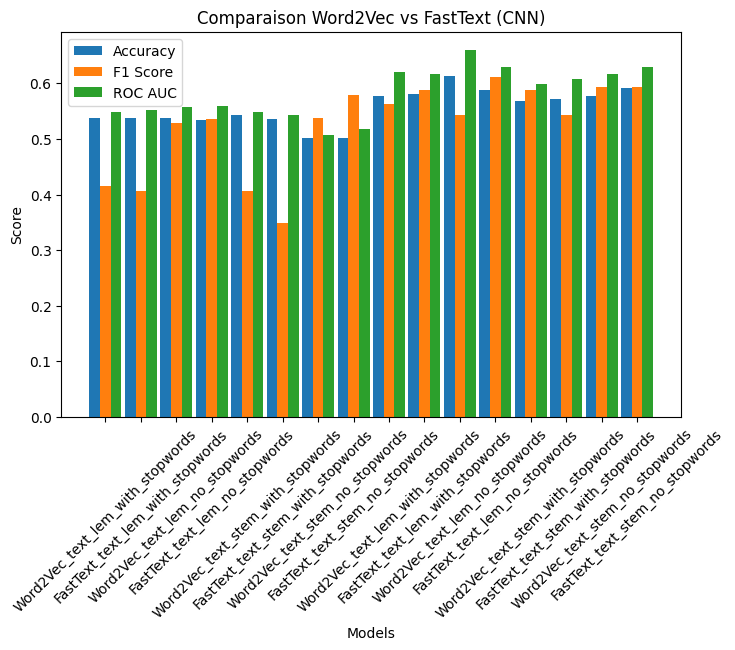

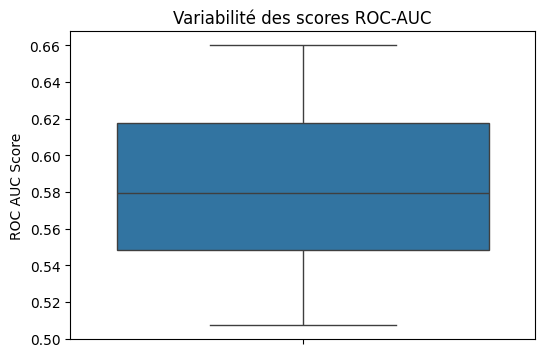

In [13]:

#  Construire un modèle CNN
def build_cnn_model(embedding_matrix):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, 
                  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        SpatialDropout1D(0.3),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model

#  Entraîner et comparer les modèles
for embedding_name in embedding_models.keys():
    print(f"\n  Entraînement du modèle CNN avec {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]
    
    #  Transformation des données avec PyTorch
    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)



    # Construire le modèle CNN avec TensorFlow
    model = build_cnn_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"CNN_{embedding_name}")

    with mlflow.start_run(run_name=f"CNN_{embedding_name}"):

        # Entraînement du modèle avec les données transformées depuis PyTorch
        history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

        #  Prédiction
        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        #  Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        #  Enregistrement dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.keras.log_model(model, f"cnn_{embedding_name}_model")

        print(f" Modèle {embedding_name} : Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

        #  Stocker les scores
        model_scores.append((embedding_name, accuracy, f1, roc_auc))

        #  Visualisation
        plot_confusion_matrix(y_test, y_pred, f"CNN {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"CNN {embedding_name}")
mlflow.end_run()

#  Comparaison des modèles avec Bar Chart et Boxplot
plot_bar_chart(model_scores, "Comparaison Word2Vec vs FastText (CNN)")
roc_auc_values = [score[3] for score in model_scores]  
plot_boxplot(roc_auc_values, "Variabilité des scores ROC-AUC")


# Adding LSTM to CNN



  Entraînement du modèle CNN + LSTM avec Word2Vec_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 43s 343ms/step - loss: 0.7004 - accuracy: 0.5041 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 37s 334ms/step - loss: 0.6948 - accuracy: 0.5142 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/10
110/110 [==============================] - 37s 333ms/step - loss: 0.6936 - accuracy: 0.5121 - val_loss: 0.6874 - val_accuracy: 0.5493
Epoch 4/10
110/110 [==============================] - 37s 333ms/step - loss: 0.6900 - accuracy: 0.5308 - val_loss: 0.6825 - val_accuracy: 0.5573
Epoch 5/10
110/110 [==============================] - 37s 333ms/step - loss: 0.6873 - accuracy: 0.5411 - val_loss: 0.6779 - val_accuracy: 0.5727
Epoch 6/10
110/110 [==============================] - 37s 333ms/step - loss: 0.6840 - accuracy: 0.5548 - val_loss: 0.6716 - val_accuracy: 0.5840
Epoch 7/10
110/110 [==============================]

2025/03/22 22:53:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_x597opn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_x597opn\model\data\model\assets
2025/03/22 22:53:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_with_stopwords : Accuracy = 0.5943, F1 Score = 0.4764, ROC AUC = 0.6405


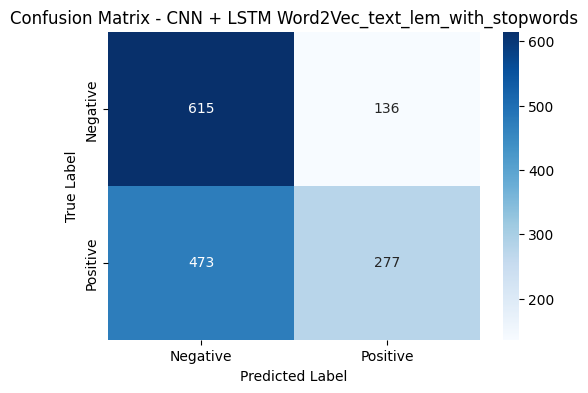

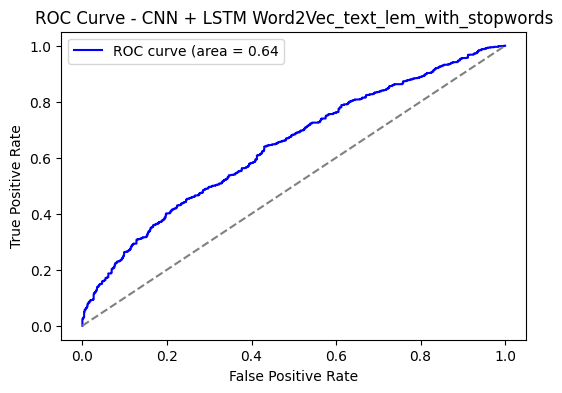


  Entraînement du modèle CNN + LSTM avec FastText_text_lem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 38s 301ms/step - loss: 0.6990 - accuracy: 0.5136 - val_loss: 0.6924 - val_accuracy: 0.5093
Epoch 2/10
110/110 [==============================] - 32s 292ms/step - loss: 0.6971 - accuracy: 0.5009 - val_loss: 0.6915 - val_accuracy: 0.5353
Epoch 3/10
110/110 [==============================] - 32s 292ms/step - loss: 0.6941 - accuracy: 0.5165 - val_loss: 0.6897 - val_accuracy: 0.5340
Epoch 4/10
110/110 [==============================] - 32s 292ms/step - loss: 0.6928 - accuracy: 0.5219 - val_loss: 0.6871 - val_accuracy: 0.5387
Epoch 5/10
110/110 [==============================] - 32s 293ms/step - loss: 0.6896 - accuracy: 0.5334 - val_loss: 0.6826 - val_accuracy: 0.5580
Epoch 6/10
110/110 [==============================] - 32s 292ms/step - loss: 0.6875 - accuracy: 0.5369 - val_loss: 0.6801 - val_accuracy: 0.5653
Epoch 7/10
110/110 [==============================]

2025/03/22 22:59:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmptgf1rkel\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmptgf1rkel\model\data\model\assets
2025/03/22 22:59:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_with_stopwords : Accuracy = 0.5843, F1 Score = 0.4212, ROC AUC = 0.6268


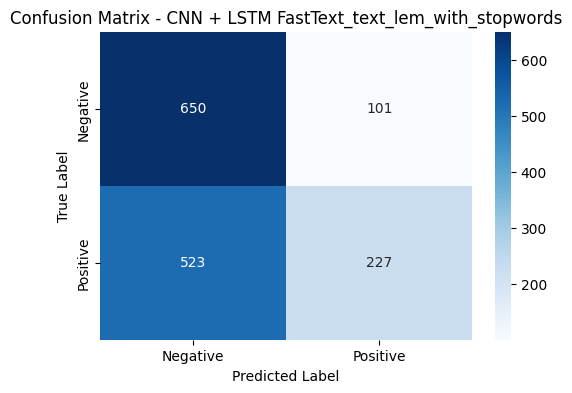

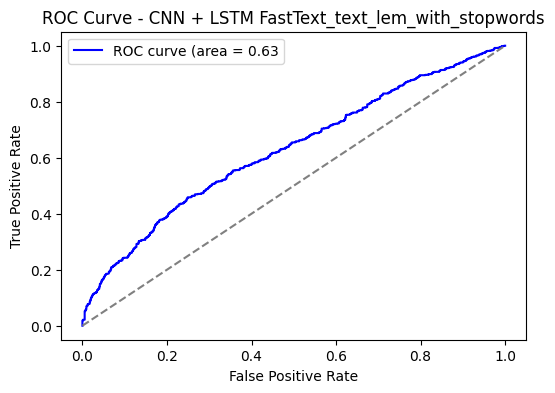


  Entraînement du modèle CNN + LSTM avec Word2Vec_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 43s 344ms/step - loss: 0.6999 - accuracy: 0.4999 - val_loss: 0.6925 - val_accuracy: 0.5073
Epoch 2/10
110/110 [==============================] - 37s 336ms/step - loss: 0.6956 - accuracy: 0.5101 - val_loss: 0.6915 - val_accuracy: 0.5287
Epoch 3/10
110/110 [==============================] - 37s 336ms/step - loss: 0.6955 - accuracy: 0.5068 - val_loss: 0.6923 - val_accuracy: 0.5293
Epoch 4/10
110/110 [==============================] - 37s 337ms/step - loss: 0.6946 - accuracy: 0.5052 - val_loss: 0.6920 - val_accuracy: 0.5313
Epoch 5/10
110/110 [==============================] - 37s 336ms/step - loss: 0.6937 - accuracy: 0.5142 - val_loss: 0.6916 - val_accuracy: 0.5353
Epoch 6/10
110/110 [==============================] - 37s 336ms/step - loss: 0.6941 - accuracy: 0.5088 - val_loss: 0.6925 - val_accuracy: 0.5280
Epoch 7/10
110/110 [==============================] -

2025/03/22 23:05:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmppbvxtjt2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmppbvxtjt2\model\data\model\assets
2025/03/22 23:06:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_lem_no_stopwords : Accuracy = 0.5050, F1 Score = 0.6578, ROC AUC = 0.5674


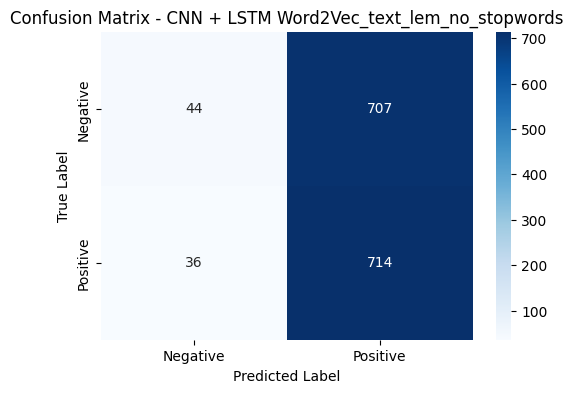

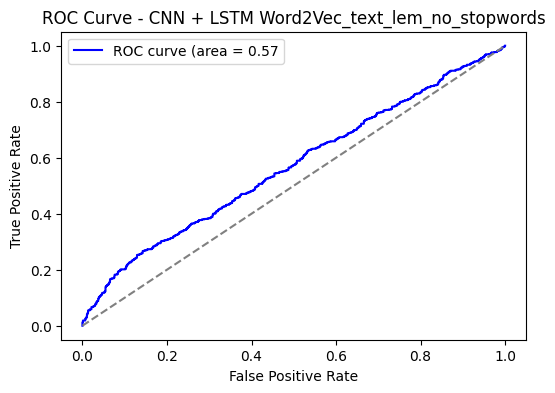


  Entraînement du modèle CNN + LSTM avec FastText_text_lem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 42s 343ms/step - loss: 0.7016 - accuracy: 0.5074 - val_loss: 0.6920 - val_accuracy: 0.5247
Epoch 2/10
110/110 [==============================] - 37s 335ms/step - loss: 0.6958 - accuracy: 0.5099 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 3/10
110/110 [==============================] - 37s 336ms/step - loss: 0.6950 - accuracy: 0.5075 - val_loss: 0.6920 - val_accuracy: 0.5287
Epoch 4/10
110/110 [==============================] - 37s 335ms/step - loss: 0.6946 - accuracy: 0.4975 - val_loss: 0.6920 - val_accuracy: 0.5273
Epoch 5/10
110/110 [==============================] - 37s 335ms/step - loss: 0.6929 - accuracy: 0.5171 - val_loss: 0.6918 - val_accuracy: 0.5320
Epoch 6/10
110/110 [==============================] - 37s 335ms/step - loss: 0.6930 - accuracy: 0.5132 - val_loss: 0.6921 - val_accuracy: 0.5267
Epoch 7/10
110/110 [==============================] -

2025/03/22 23:12:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpcxo_8vy7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpcxo_8vy7\model\data\model\assets
2025/03/22 23:13:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_lem_no_stopwords : Accuracy = 0.5556, F1 Score = 0.4255, ROC AUC = 0.5480


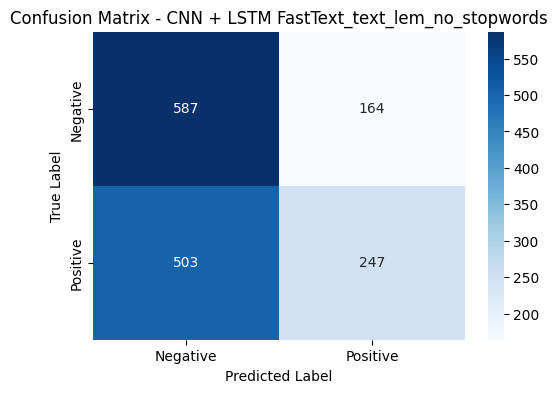

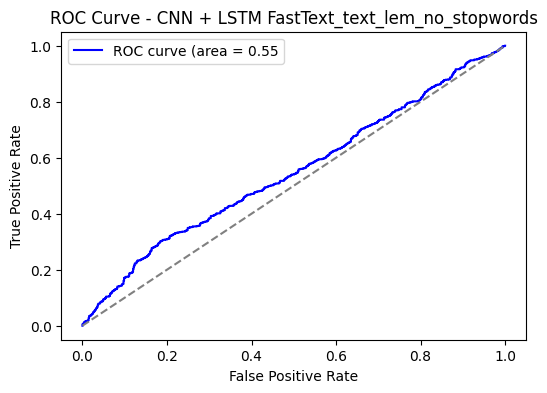


  Entraînement du modèle CNN + LSTM avec Word2Vec_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 64s 537ms/step - loss: 0.7001 - accuracy: 0.5069 - val_loss: 0.6922 - val_accuracy: 0.5047
Epoch 2/10
110/110 [==============================] - 56s 511ms/step - loss: 0.6968 - accuracy: 0.4984 - val_loss: 0.6924 - val_accuracy: 0.5280
Epoch 3/10
110/110 [==============================] - 56s 510ms/step - loss: 0.6946 - accuracy: 0.5082 - val_loss: 0.6906 - val_accuracy: 0.5293
Epoch 4/10
110/110 [==============================] - 56s 510ms/step - loss: 0.6920 - accuracy: 0.5312 - val_loss: 0.6912 - val_accuracy: 0.5047
Epoch 5/10
110/110 [==============================] - 56s 513ms/step - loss: 0.6929 - accuracy: 0.5169 - val_loss: 0.6879 - val_accuracy: 0.5473
Epoch 6/10
110/110 [==============================] - 56s 510ms/step - loss: 0.6901 - accuracy: 0.5345 - val_loss: 0.6870 - val_accuracy: 0.5220
Epoch 7/10
110/110 [==============================

2025/03/22 23:22:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzug_989h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzug_989h\model\data\model\assets
2025/03/22 23:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_with_stopwords : Accuracy = 0.5843, F1 Score = 0.4124, ROC AUC = 0.6370


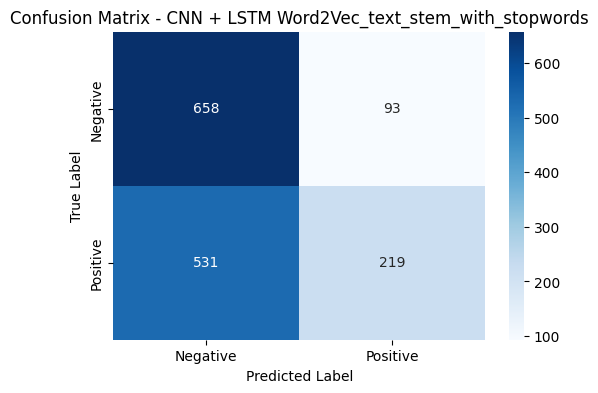

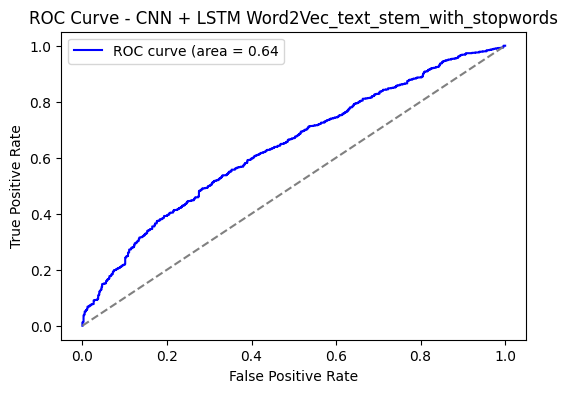


  Entraînement du modèle CNN + LSTM avec FastText_text_stem_with_stopwords...

Epoch 1/10
110/110 [==============================] - 46s 374ms/step - loss: 0.6998 - accuracy: 0.5048 - val_loss: 0.6905 - val_accuracy: 0.5313
Epoch 2/10
110/110 [==============================] - 40s 365ms/step - loss: 0.6951 - accuracy: 0.5132 - val_loss: 0.6910 - val_accuracy: 0.5480
Epoch 3/10
110/110 [==============================] - 40s 366ms/step - loss: 0.6931 - accuracy: 0.5171 - val_loss: 0.6864 - val_accuracy: 0.5480
Epoch 4/10
110/110 [==============================] - 40s 366ms/step - loss: 0.6909 - accuracy: 0.5308 - val_loss: 0.6850 - val_accuracy: 0.5480
Epoch 5/10
110/110 [==============================] - 40s 367ms/step - loss: 0.6881 - accuracy: 0.5409 - val_loss: 0.6809 - val_accuracy: 0.5513
Epoch 6/10
110/110 [==============================] - 40s 365ms/step - loss: 0.6838 - accuracy: 0.5479 - val_loss: 0.6758 - val_accuracy: 0.5713
Epoch 7/10
110/110 [==============================

2025/03/22 23:30:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpm8345dlh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpm8345dlh\model\data\model\assets
2025/03/22 23:30:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_with_stopwords : Accuracy = 0.5989, F1 Score = 0.5487, ROC AUC = 0.6355


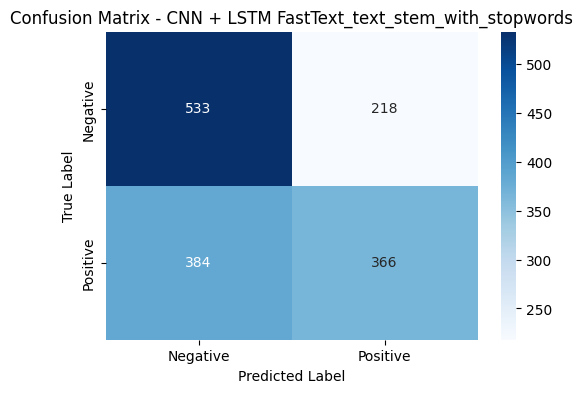

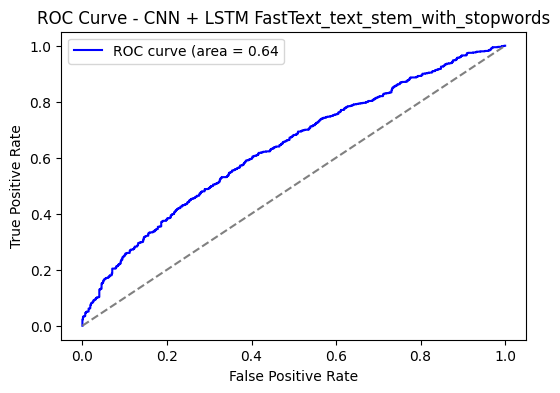


  Entraînement du modèle CNN + LSTM avec Word2Vec_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 45s 370ms/step - loss: 0.7004 - accuracy: 0.5068 - val_loss: 0.6932 - val_accuracy: 0.5013
Epoch 2/10
110/110 [==============================] - 40s 361ms/step - loss: 0.6961 - accuracy: 0.5026 - val_loss: 0.6914 - val_accuracy: 0.5267
Epoch 3/10
110/110 [==============================] - 40s 362ms/step - loss: 0.6943 - accuracy: 0.5119 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/10
110/110 [==============================] - 40s 361ms/step - loss: 0.6950 - accuracy: 0.5085 - val_loss: 0.6924 - val_accuracy: 0.5267
Epoch 5/10
110/110 [==============================] - 40s 361ms/step - loss: 0.6938 - accuracy: 0.5149 - val_loss: 0.6918 - val_accuracy: 0.5253
Epoch 6/10
110/110 [==============================] - 40s 361ms/step - loss: 0.6930 - accuracy: 0.5116 - val_loss: 0.6912 - val_accuracy: 0.5313
Epoch 7/10
110/110 [==============================] 

2025/03/22 23:37:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpdaw97d3y\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpdaw97d3y\model\data\model\assets
2025/03/22 23:37:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle Word2Vec_text_stem_no_stopwords : Accuracy = 0.4983, F1 Score = 0.5573, ROC AUC = 0.5173


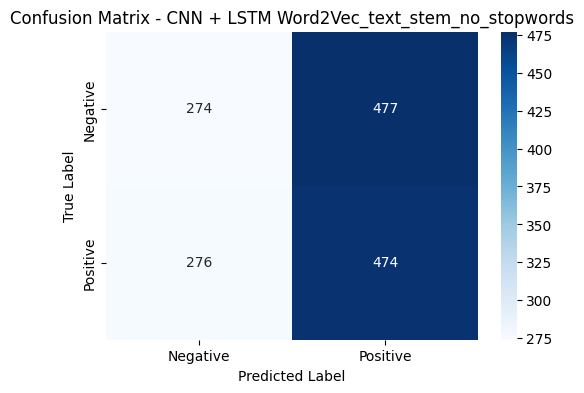

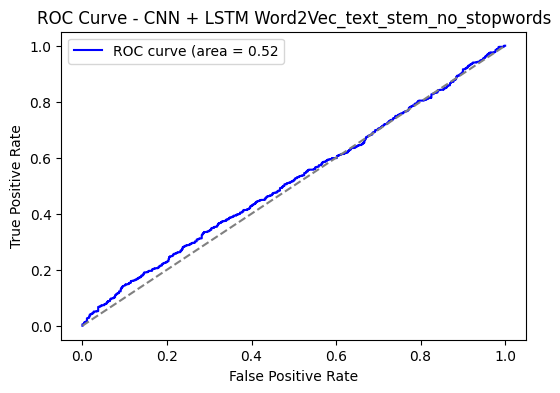


  Entraînement du modèle CNN + LSTM avec FastText_text_stem_no_stopwords...

Epoch 1/10
110/110 [==============================] - 65s 552ms/step - loss: 0.6986 - accuracy: 0.5005 - val_loss: 0.6923 - val_accuracy: 0.5300
Epoch 2/10
110/110 [==============================] - 59s 535ms/step - loss: 0.6962 - accuracy: 0.4941 - val_loss: 0.6919 - val_accuracy: 0.5273
Epoch 3/10
110/110 [==============================] - 59s 535ms/step - loss: 0.6948 - accuracy: 0.4948 - val_loss: 0.6919 - val_accuracy: 0.5320
Epoch 4/10
110/110 [==============================] - 59s 535ms/step - loss: 0.6938 - accuracy: 0.5092 - val_loss: 0.6924 - val_accuracy: 0.5073
Epoch 5/10
110/110 [==============================] - 59s 534ms/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6924 - val_accuracy: 0.5067
Epoch 6/10
110/110 [==============================] - 59s 533ms/step - loss: 0.6928 - accuracy: 0.5069 - val_loss: 0.6919 - val_accuracy: 0.5287
Epoch 7/10
110/110 [==============================] 

2025/03/22 23:47:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpll3k8eh7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpll3k8eh7\model\data\model\assets
2025/03/22 23:48:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modèle FastText_text_stem_no_stopwords : Accuracy = 0.5370, F1 Score = 0.2470, ROC AUC = 0.5994


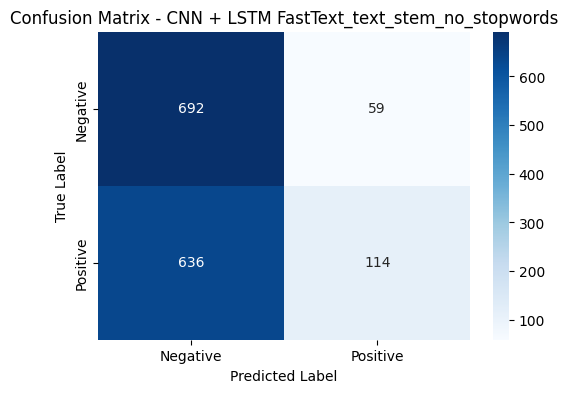

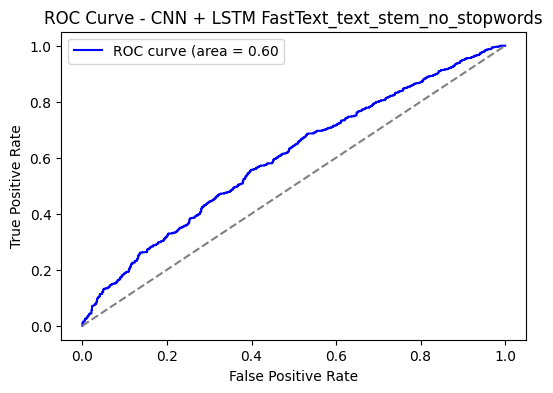

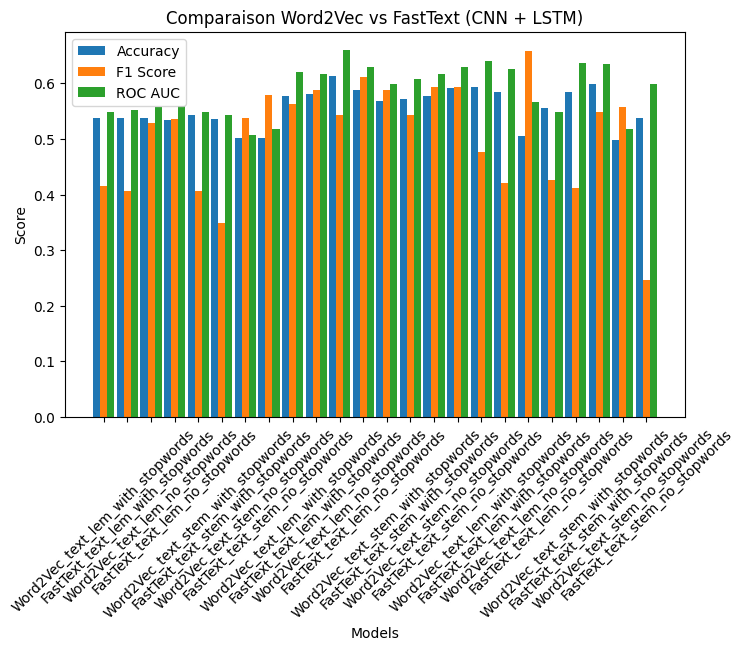

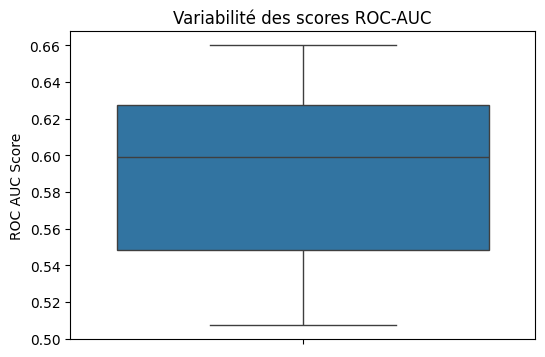

In [14]:

#  Construire un modèle CNN + LSTM
def build_cnn_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, 
                  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        SpatialDropout1D(0.3),

        # Convolution pour extraire les patterns locaux
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),

        # Ajout de LSTM pour capturer les dépendances globales
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dropout(0.5),

        # Classification
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    
    return model

#  Entraîner et comparer les modèles
for embedding_name in embedding_models.keys():
    print(f"\n  Entraînement du modèle CNN + LSTM avec {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]
    
    #  Transformation des données avec PyTorch
    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)


    # Construire le modèle CNN + LSTM avec TensorFlow
    model = build_cnn_lstm_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"CNN_LSTM_{embedding_name}")

    with mlflow.start_run(run_name=f"CNN_LSTM_{embedding_name}"):

        # Entraînement du modèle avec les données transformées depuis PyTorch
        history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

        #  Prédiction
        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        #  Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        #  Enregistrement dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.keras.log_model(model, f"cnn_lstm_{embedding_name}_model")

        print(f" Modèle {embedding_name} : Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

        #  Stocker les scores
        model_scores.append((embedding_name, accuracy, f1, roc_auc))

        #  Visualisation
        plot_confusion_matrix(y_test, y_pred, f"CNN + LSTM {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"CNN + LSTM {embedding_name}")
mlflow.end_run()

#  Comparaison des modèles avec Bar Chart et Boxplot
plot_bar_chart(model_scores, "Comparaison Word2Vec vs FastText (CNN + LSTM)")
roc_auc_values = [score[3] for score in model_scores]  
plot_boxplot(roc_auc_values, "Variabilité des scores ROC-AUC")


# Modèle Transformer (BERT)

In [18]:
# 1. Config
model_name = "distilbert-base-uncased"
batch_size = 32
epochs = 3
learning_rate = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tokenizer & modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Ajouter le token <OOV> s’il n’existe pas
if "<OOV>" not in tokenizer.get_vocab():
    tokenizer.add_tokens(["<OOV>"])  # étend le vocabulaire

# Étendre l'embedding du modèle pour inclure ce nouveau token
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
model.resize_token_embeddings(len(tokenizer))
# 3. Dataset custom
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# 4. Préparation des datasets
train_dataset = TextDataset(X_train["text_bert"].tolist(), y_train.tolist())
val_dataset = TextDataset(X_val["text_bert"].tolist(), y_val.tolist())
test_dataset = TextDataset(X_test["text_bert"].tolist(), y_test.tolist())


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:




# 5. Entraînement + MLflow
mlflow.set_experiment("DISTILBERT_MODEL")

with mlflow.start_run():
    mlflow.log_params({
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Époque {epoch+1} terminée - perte moyenne : {total_loss/len(train_loader):.4f}")

    # 6. Évaluation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f" Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc
    })

    # 7. Sauvegarde du modèle
    torch.save(model.state_dict(), "DISTILBERT_MODEL.pt")
    mlflow.log_artifact("DISTILBERT_MODEL.pt")


Epoch 1/3:   0%|          | 0/219 [00:00<?, ?it/s]


TypeError: '>=' not supported between instances of 'list' and 'int'

In [8]:
# Enregistrement des visualisations
def save_and_log_plot(plot_func, filename, *args, **kwargs):
    """Sauvegarde et enregistre un graphe dans MLflow."""
    #filepath = os.path.join(plots_dir, filename)
    plot_func(*args, **kwargs)  # Génère le graphe
    #plt.savefig(filepath)  # Sauvegarde en fichier image
    #mlflow.log_artifact(filepath)  # Log dans MLflow
    plt.close()  # Ferme la figure pour éviter les erreurs

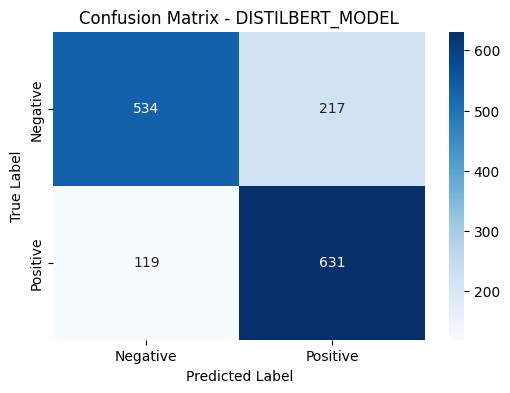

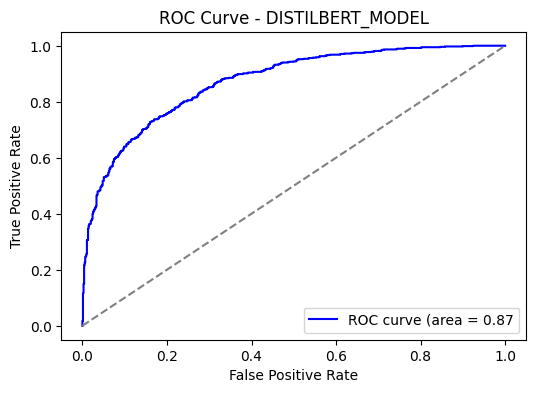

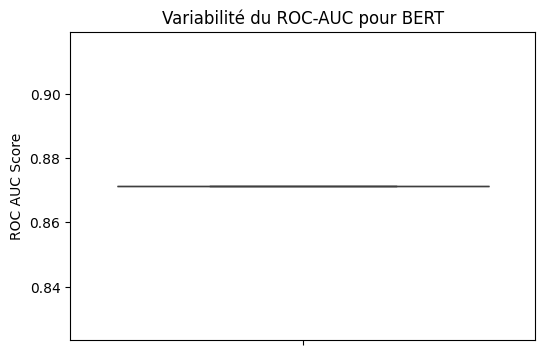

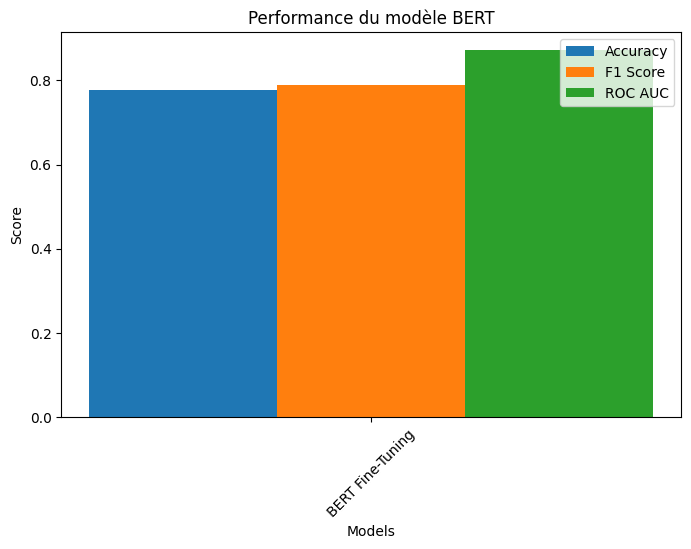

In [ ]:



# 8. Visualisations dans MLflow
save_and_log_plot(plot_confusion_matrix, "confusion_matrix.png", all_labels, all_preds, model_name="DISTILBERT_MODEL")
save_and_log_plot(plot_roc_curve, "roc_curve.png", all_labels, all_probs, model_name="DISTILBERT_MODEL")
save_and_log_plot(plot_boxplot, "roc_auc_variability.png", [roc_auc], title="Variabilité du ROC-AUC pour BERT")
save_and_log_plot(
    plot_bar_chart,
    "performance_comparison.png",
    [("BERT Fine-Tuning", accuracy, f1, roc_auc)],
    title="Performance du modèle BERT"
)
mlflow.end_run()


# Roberta Twitter

In [19]:
# 1. Config
from transformers import RobertaConfig
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [ ]:
# 1. Config
batch_size = 32
epochs = 3
learning_rate = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tokenizer & modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Ajouter le token <OOV> s’il n’existe pas
if "<OOV>" not in tokenizer.get_vocab():
    tokenizer.add_tokens(["<OOV>"])  # étend le vocabulaire

# Étendre l'embedding du modèle pour inclure ce nouveau token
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
model.resize_token_embeddings(len(tokenizer))
# 3. Dataset custom
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# 4. Préparation des datasets
train_dataset = TextDataset(X_train["text_bert"].tolist(), y_train.tolist())
val_dataset = TextDataset(X_val["text_bert"].tolist(), y_val.tolist())
test_dataset = TextDataset(X_test["text_bert"].tolist(), y_test.tolist())


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer vocab size: 50266
Model embedding size: 50266


In [20]:




# 5. Entraînement + MLflow
mlflow.set_experiment("ROBERTA_MODEL")



with mlflow.start_run():
    mlflow.log_params({
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Époque {epoch+1} terminée - perte moyenne : {total_loss/len(train_loader):.4f}")

    # 6. Évaluation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f" Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc
    })


    # 7. Sauvegarde du modèle
    torch.save(model.state_dict(), "ROBERTA_MODEL.pt")
    mlflow.log_artifact("ROBERTA_MODEL.pt")


Epoch 1/3: 100%|██████████| 219/219 [36:43<00:00, 10.06s/it]


Époque 1 terminée - perte moyenne : 0.5044


Epoch 2/3: 100%|██████████| 219/219 [37:38<00:00, 10.31s/it]


Époque 2 terminée - perte moyenne : 0.3201


Epoch 3/3: 100%|██████████| 219/219 [37:32<00:00, 10.29s/it]


Époque 3 terminée - perte moyenne : 0.1695
 Accuracy: 0.7635, F1 Score: 0.7690, ROC AUC: 0.8520


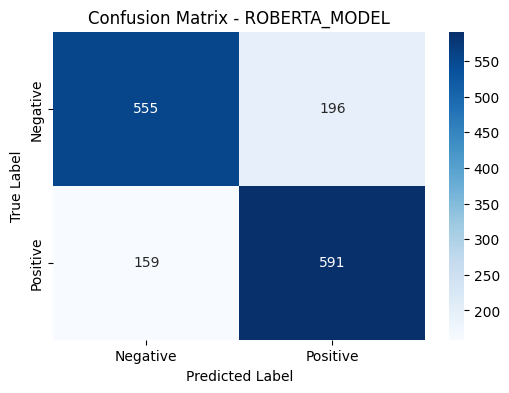

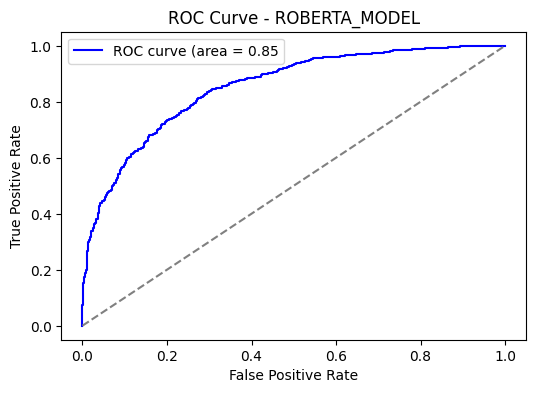

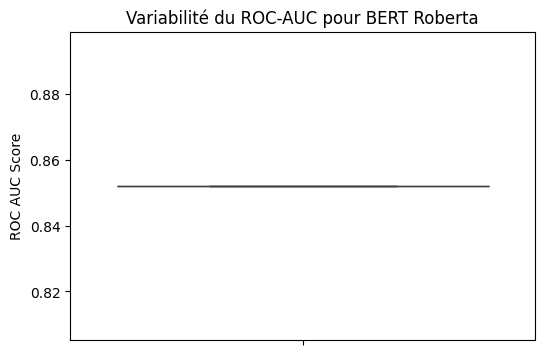

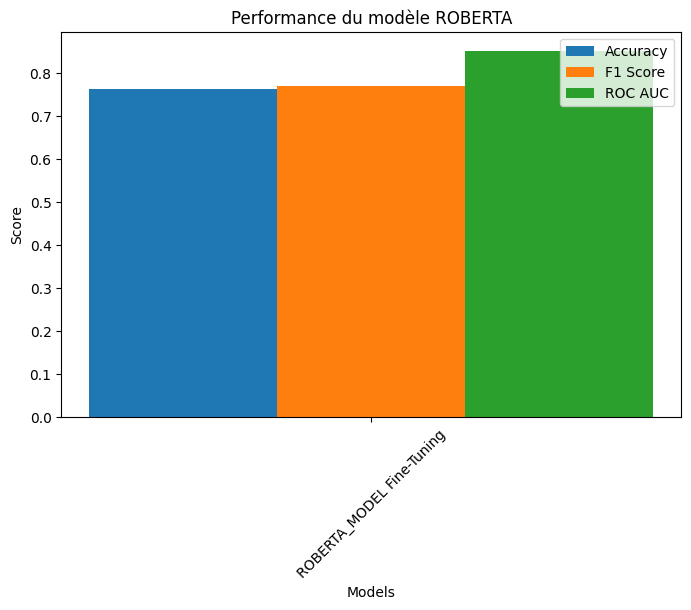

In [21]:
# 8. Visualisations dans MLflow
save_and_log_plot(plot_confusion_matrix, "confusion_matrix.png", all_labels, all_preds, model_name="ROBERTA_MODEL")
save_and_log_plot(plot_roc_curve, "roc_curve.png", all_labels, all_probs, model_name="ROBERTA_MODEL")
save_and_log_plot(plot_boxplot, "roc_auc_variability.png", [roc_auc], title="Variabilité du ROC-AUC pour BERT Roberta")
save_and_log_plot(
    plot_bar_chart,
    "performance_comparison.png",
    [("ROBERTA_MODEL Fine-Tuning", accuracy, f1, roc_auc)],
    title="Performance du modèle ROBERTA"
)

mlflow.end_run()